In [1]:
import xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score,cross_val_predict
import matplotlib.pyplot as plt
import os
from scipy.stats.stats import pearsonr
import xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score,cross_val_predict
import matplotlib.pyplot as plt
import os
from datetime import timedelta
from scipy.stats.stats import pearsonr
global_path='/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/predictor/'

In [2]:
conn_daya = pd.read_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/predictor/meal_features_t1d.csv')[['ConnectionID', 'Timestamp']]
conn_daya['Day'] = conn_daya['Timestamp'].str[:10]
conns_days = conn_daya[['ConnectionID', 'Day']].drop_duplicates()


def preprocess_X1(X_path, control_predictor, max_gl, without_micr):
    X = pd.read_csv(X_path).set_index(['ConnectionID', 'MealEventID'])
    print('after merging and crowd filtering', X.shape[0])
    X_orig = X
#    X_bad = X[X['BolusInsulinMeal_90_15']<0.1]
#    X_bad = X_bad[X_bad['Carbohydrate_g']>15]
#    X = X[~X.index.isin(X_bad.index)] 
  #  print('after removing with 15 gr of carbs and bolus less than 0.1', X.shape[0])
 #   susp = [5410, 5425, 3523]
    X = X[[col for col in X.columns if col not in ['InsulinBeforeMeal_10_30', 'BolusInsulinMeal_-15_120', 'InsulinBeforeMeal_060','InsulinBeforeMeal_12035', 'InsulinBeforeMeal_240120','InsulinBeforeMeal_120120',  'InsulinBeforeMeal_12030']]]        
#    X = X[~X.index.get_level_values(0).isin(susp)]
 #   print('after removing with 3 connections that we though were bad', X.shape[0])
    micr_columns= [col for col in X.columns if 'k__Bacteria' in col or col in ['firm_to_bact_ratio', 'shannon_divercity', 'richness',
       'propionate_producing', 'accetate_producing', 'akkermania', 'alipastes',
       'roseburia', 'eubacterium', 'butirate_producing', 'faecalibacterium',
       'subdoligranulum', 'christensenella'] ]
    for col in X.columns:
        if 'InsulinBefore' in col and not control_predictor:
            X[col+'_normed'] = X[col]/X['BodyWeight']
        if col in micr_columns and without_micr:
            del X[col]
    y = pd.read_csv('computed_ppgrs_t1d.csv').set_index(['ConnectionID', 'MealEventID'])['y']
    if max_gl:
        y = pd.read_csv('t1d_max2hrs.csv').set_index(['ConnectionID', 'MealEventID'])['Glucose_max_2hrs']
        X = X.sort_index()
        y = y.sort_index()
        y = y - X['SugarAtMealStart']
        y = y.apply(lambda x: -100 if x<-100 else x)
        y = y.apply(lambda x: 200 if x>200 else x)
    X = X.sort_index()
    y = y.sort_index()
    X = X[X['Carbohydrate_g']<200]
    print('after removing with carbs more than 200', X.shape[0])
    X = X[X['InsulinBeforeMeal_240_15']>0]
    print('after removing withiout basal insulin', X.shape[0])
    X = X[X['SugarAtMealStart']>49]
    print('after removing withiout sugar in meal start less than 50', X.shape[0])
    if control_predictor:
        X = X[[ 'Carbohydrate_g', 'SugarAtMealStart', 'Timestamp', 'BolusInsulinMeal_90_15']]

    if 'Exercise_timeToNext' in X.columns:
        del X['Exercise_timeToNext']
    
    
    return X,y
X_chec,y =preprocess_X1('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/predictor/meal_features_t1d.csv', False,False,False)

Xconn_days =X_chec.reset_index()[['ConnectionID', 'Timestamp']]
conn_daya['Day'] = conn_daya['Timestamp'].str[:10]
conns_days = conn_daya[['ConnectionID', 'Day']].drop_duplicates()


start= X_chec.groupby(X_chec.index.get_level_values(0))['Timestamp'].min()
start.name = 'Conn_start'
X_chec = X_chec.join(start)[['Conn_start', 'Timestamp']]
X_chec[pd.to_datetime(X_chec['Timestamp'])<pd.to_datetime(X_chec['Conn_start'])+timedelta(days=15)]

after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486


Conn_start            Timestamp
ConnectionID MealEventID                                          
2866         212819.0     2017-10-11 10:04:53  2017-10-11 10:04:53
             212872.0     2017-10-11 10:04:53  2017-10-11 12:39:40
             212986.0     2017-10-11 10:04:53  2017-10-11 20:54:00
             213207.0     2017-10-11 10:04:53  2017-10-12 11:37:25
             215309.0     2017-10-11 10:04:53  2017-10-18 14:07:41
...                                       ...                  ...
5943         377864.0     2018-07-04 13:31:46  2018-07-16 21:44:56
             378675.0     2018-07-04 13:31:46  2018-07-17 10:00:26
             378678.0     2018-07-04 13:31:46  2018-07-17 14:41:13
             378683.0     2018-07-04 13:31:46  2018-07-17 18:32:39
             378686.0     2018-07-04 13:31:46  2018-07-17 22:05:57

[6377 rows x 2 columns]

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

Definitions and functions

In [4]:
global_path='/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/predictor/'
def fit_the_model_on_healthy_participants():
    X_all = pd.read_csv(os.path.join(global_path, 'X_all_studies.csv')).set_index('ConnectionID', 'MealEventID')
    y_all = pd.read_csv(os.path.join(global_path, 'y_all_studies.csv')).set_index('ConnectionID', 'MealEventID')['y']
    model = xgboost.XGBRegressor(learning_rate = 0.005, n_estimators = 3000, reg_lambda = 10, subsample = 0.75, \
                                        colsample_bytree = 0.4, max_depth = 60, reg_alpha = 10, min_child_weight = 50, nthread = 4, seed = 5)
    del X_all['Timestamp']
    est1 = model
    est1.fit(X_all, y_all)
    return est1


def do_correl_pearson(ser1, ser2, name2 = 'Measured Value', name1 = 'Predicted Value', ax = 0,
                     ylim1=None, ylim2=None):
      
        if ax==0:              
            fig = plt.figure(figsize = (5,5))            
            ax = fig.add_subplot(111)
        joined = pd.concat([ser2,ser1], axis = 1).dropna()
        ax.plot(joined[ser1.name], joined[ser2.name], 'o', color = 'DarkGrey', markersize = 3, mew = 0, alpha = 0.7)
        print(pearsonr(joined[ser1.name], joined[ser2.name]))
        ax.set_xlabel(name1,fontsize=14)
        ax.set_ylabel(name2, fontsize=14)
        if ylim1 is not None:
            ax.set_ylim(ylim1, ylim2)
        ax.grid()

        
        return 0

control_predictor = False
max_gl = True
without_micr = False
from scipy.stats import rankdata
import seaborn as sns
X_path =os.path.join(global_path, 'meal_features_t1d_segata.csv')
def preprocess_X(X_path, control_predictor, max_gl, without_micr):
    X = pd.read_csv(X_path).set_index(['ConnectionID', 'MealEventID'])
    print('after merging and crowd filtering', X.shape[0])
    X_orig = X

    X = X[[col for col in X.columns if col not in ['InsulinBeforeMeal_10_30', 'BolusInsulinMeal_-15_120', 'InsulinBeforeMeal_060','InsulinBeforeMeal_12035', 'InsulinBeforeMeal_240120','InsulinBeforeMeal_120120',  'InsulinBeforeMeal_12030']]]        
    micr_columns= [col for col in X.columns if 'k__Bacteria' in col ]
    for col in X.columns:
        if 'InsulinBefore' in col and not control_predictor:
            X[col+'_normed'] = X[col]/X['BodyWeight']
        if col in micr_columns and without_micr:
            del X[col]
    y = pd.read_csv('computed_ppgrs_t1d.csv').set_index(['ConnectionID', 'MealEventID'])['y']
    if max_gl:
        y = pd.read_csv('t1d_max2hrs.csv').set_index(['ConnectionID', 'MealEventID'])['Glucose_max_2hrs']
        X = X.sort_index()
        y = y.sort_index()
        y = y - X['SugarAtMealStart']
        y = y.apply(lambda x: -100 if x<-100 else x)
        y = y.apply(lambda x: 200 if x>200 else x)
    X = X.sort_index()
    y = y.sort_index()
    X = X[X['Carbohydrate_g']<200]
    print('after removing with carbs more than 200', X.shape[0])
    X = X[X['InsulinBeforeMeal_240_15']>0]
    print('after removing withiout basal insulin', X.shape[0])
    X = X[X['SugarAtMealStart']>49]
    print('after removing withiout sugar in meal start less than 50', X.shape[0])
    if control_predictor:
        X = X[[ 'Carbohydrate_g', 'SugarAtMealStart', 'Timestamp', 'BolusInsulinMeal_90_15']]
    start= X.groupby(X.index.get_level_values(0))['Timestamp'].min()
    start.name = 'Conn_start'
    X = X.join(start)
    X = X[pd.to_datetime(X['Timestamp'])<pd.to_datetime(X_chec['Conn_start'])+timedelta(days=15)]
    del X['Conn_start']
    print('after removing meals that are more than 15 days after the forst', X.shape[0])
    if 'Timestamp' in X.columns:
        del X['Timestamp']
    if 'Exercise_timeToNext' in X.columns:
        del X['Exercise_timeToNext']
    return X,y
        
def predict_with_cv(X,y):
    model = xgboost.XGBRegressor(learning_rate = 0.005, n_estimators = 3000, reg_lambda = 10, subsample = 0.75, \
                                    colsample_bytree = 0.4, max_depth = 60, reg_alpha = 10, min_child_weight = 50, nthread = 4, seed = 5)
    
    
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score
from pingouin import partial_corr

def cvfolds_by_person(X):
    res = []
    for train, test in KFold( n_splits = 10, shuffle = True, random_state = 5).split(X.groupby(X.index.get_level_values(0))):
        testfilt = X.index.get_level_values(0).isin(X.index.levels[0][test])
        res.append((np.where(~testfilt), np.where(testfilt)))
    return res

def fdr(p_vals):
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

def predict_and_estimate(X,y, name1 = 'Measured PPGR mg/dl',  name2 = 'Predicted PPGR, mg/dl', ylim1=None,
                        ylim2 = None):
    X = X[X.index.isin(y.index)]
    y = y[y.index.isin(X.index)]

    model = xgboost.XGBRegressor(learning_rate = 0.005, n_estimators = 2000, reg_lambda = 10, subsample = 0.75, \
                                    colsample_bytree = 0.4, max_depth = 60, reg_alpha = 10, min_child_weight = 50, nthread = 4, seed = 5)
    
    bins = np.linspace(0, y.shape[0], 50)
    y_binned = np.digitize(y, bins)
    kfold = StratifiedKFold(n_splits=10, random_state=17, shuffle=True)

    results = cross_val_predict(model, X, y,cv=kfold.split(X, y_binned))
   # results = cross_val_predict(model, X.values, y.values, cv=list(group_kfold.split(X, y, X.reset_index()['ConnectionID'].values)))
    pred_real = pd.DataFrame(columns = ['y_test', 'y_pred'])
    pred_real['y_test']=y
    i=0
    for ind in y.index:
        pred_real.loc[ind, 'y_pred']=results[i]
        i = i+1
    print('r squared', r2_score(pred_real['y_test'].values, pred_real['y_pred'].values))
    do_correl_pearson(pred_real['y_test'], pred_real['y_pred'], name2 = name2, name1 = name1,ylim1=ylim1, ylim2=ylim2)    
    return pred_real

def do_pearson(ser1, ser2, name1='microbiome column', name2='phenotype column'):
    joined = pd.concat([ser1, ser2], axis=1).dropna()
    return pearsonr(joined[ser1.name], joined[ser2.name]) 

def do_correl_pearson_numb_adj(ser1, ser2, covar):
        joined = pd.concat([ser1,ser2, covar], axis = 1).dropna()
        return  partial_corr(joined, ser1.name,ser2.name, covar.name)[['r', 'p-val']].values[0]

def bacteria_name(x):
    if '|' not in x:
        return x
    if x.split('|')[6].replace('s__', '')!='unknown':
        return x.split('|')[6].replace('s__', '')+' '+x.split('|')[9]
    elif x.split('|')[5].replace('g__', '')!='unknown':
        return x.split('|')[5].replace('g__', '')+' '+x.split('|')[9]
    elif x.split('|')[4].replace('f__', '')!='unknown':
        return x.split('|')[4].replace('f__', '')+' '+x.split('|')[9]
    else:
        return x.split('|')[9]
    
    
def do_a_heatmap_and_corr_matrix(A, B, title=''):
    A = A.rename(columns = {col:rename_bact_name(col) for col in A.columns})
    A = A[[col for col in A.columns if 'unknown' not in col]]
    res_pval = pd.DataFrame()
    res_corr = pd.DataFrame()

            
            
    for col1 in A.columns:
        for col2 in B.columns:
            if col1==col2 or col2=='Age' or col1=='Age':
                continue

            res_pval.loc[col1, col2] = do_correl_pearson_numb_adj(A[col1], B[col2], B['Age'])[1]
            res_corr.loc[col1, col2] = do_correl_pearson_numb_adj(A[col1], B[col2], B['Age'])[0]
        

    sign_corr = pd.DataFrame()
    sign_pval = pd.DataFrame()

    for col in res_pval.columns:
        print('shape!!!', res_pval[col].shape)
        new_pval = fdr(res_pval[col]).sort_values()
        signif = new_pval[new_pval < 0.1]
        if signif.shape[0] > 0:
            for ind in signif.index:
                print(ind, signif.loc[ind])
                sign_corr.loc[ind, col] = res_corr.loc[ind, col]
                sign_pval.loc[ind, col] = res_pval.loc[ind, col]
    sign_pval.to_csv(os.path.join(global_path, 'pvalues_'+title+'.csv' ))
    sign_corr.to_csv(os.path.join(global_path,'corr_' + title + '.csv'))
    fig, ax = plt.subplots(figsize = (7, 9))
    cmap = sns.diverging_palette(230,0, 90, 60, as_cmap=True)
# plot heatmap
    sns.heatmap(sign_corr.fillna(0).T, annot=False, fmt=".2f", 
           linewidths=0, cmap=cmap, vmin=-1, vmax=1, square=True, cbar=False)
   # plt.show()
    fig.savefig('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//predictor//sign_corr_'+title+'.png' )
 #   fig.savefig('/net/mraid08/export/genie/LabData/Data/StudySpecificData/tenk_itamar//sign_corr_'+title+'.png' )
    
    
def predict_and_estimate_small(X,y, name1 = 'Measured PPGR mg/dl',  name2 = 'Predicted PPGR, mg/dl'):
    X = X[X.index.isin(y.index)]
    y = y[y.index.isin(X.index)]

    model = xgboost.XGBRegressor()
    
    bins = np.linspace(0, y.shape[0], 5)
    y_binned = np.digitize(y, bins)
    kfold = StratifiedKFold(n_splits=5, random_state=17, shuffle=True)

    results = cross_val_predict(model, X, y,cv=kfold.split(X, y_binned))
   # results = cross_val_predict(model, X.values, y.values, cv=list(group_kfold.split(X, y, X.reset_index()['ConnectionID'].values)))
    pred_real = pd.DataFrame(columns = ['y_test', 'y_pred'])
    pred_real['y_test']=y
    i=0
    for ind in y.index:
        pred_real.loc[ind, 'y_pred']=results[i]
        i = i+1
    print('r squared', r2_score(pred_real['y_test'].values, pred_real['y_pred'].values))
    do_correl_pearson(pred_real['y_test'], pred_real['y_pred'], name2 = name2, name1 = name1)    
    return pred_real

def stacked_hist(ser1, ser2, title=''):
    fig = plt.figure(figsize = (5,4))            
    ax = fig.add_subplot(111)
    plt.hist([ser1,ser2], 40, stacked=True, density=False, edgecolor='black', linewidth=1)
    ax.set_xlabel(title)
    #plt.title(title)
    plt.show()


#groups =cvfolds(X)

#group_kfold = GroupKFold(n_splits=10)

#group_kfold.split(X, y, X.reset_index()['ConnectionID'].values)
    

/home/godnean/.local/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


test the predictor on healthy population

after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377
(0.39919008048001275, 1.2725363029292008e-242)
r squared 0.34640289310369043
(0.5885917493046167, 0.0)


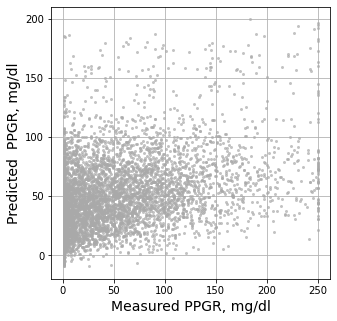

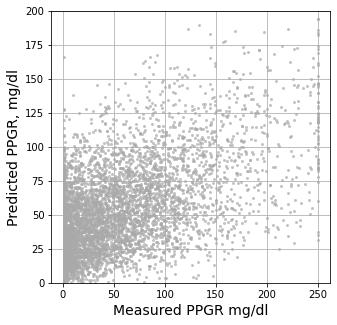

In [340]:
X,y = preprocess_X(X_path, control_predictor=False, max_gl=False, without_micr=False)

X = X.join(predicted_old[['y_pred']].astype(float))
X = X[X.index.isin(y.index)].sort_index()
y = y[y.index.isin(X.index)].sort_index()
predicted_old['y_test']=y
X_all = pd.read_csv(os.path.join(global_path, 'X_all_studies.csv')).set_index('ConnectionID', 'MealEventID')
X1 = pd.read_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/predictor/meal_features_t1d.csv').set_index(['ConnectionID', 'MealEventID'])
X1 = X1[X1.index.isin(X.index)]
del X1['Timestamp']
del X_all['Timestamp']
result_old = est1.predict(X1.reset_index()[X_all.columns])

i=0
for ind in y.index:
    predicted_old.loc[ind, 'y_pred']=result_old[i]
    i = i+1
do_correl_pearson( predicted_old['y_test'], predicted_old['y_pred'], name1 = 'Measured PPGR, mg/dl', name2 = 'Predicted  PPGR, mg/dl')    


del X['RegistrationCode']
predicte_vs_measured = predict_and_estimate(X,y,name1 = 'Measured PPGR mg/dl', 
                                            name2 = 'Predicted PPGR, mg/dl',ylim1=0, ylim2=200)
predicte_vs_measured.to_csv(os.path.join(global_path, 'predicted_vs_measured_maxglu_complete_with_old.csv'))

prediction of the ppgr

after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377
r squared 0.34616841290836664
(0.5883980865763672, 0.0)
after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377
r squared 0.16050514141232508
(0.40311888159158143, 7.943493588068153e-248)
after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377
(0.15976889235882646, 9.969642373201791e-38)


0

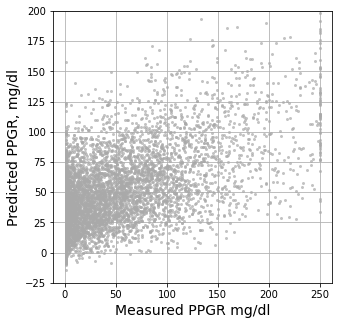

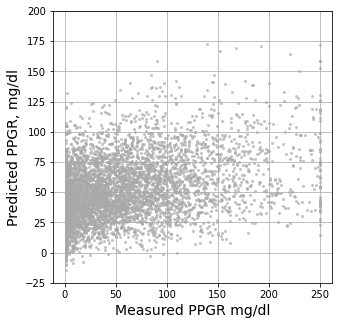

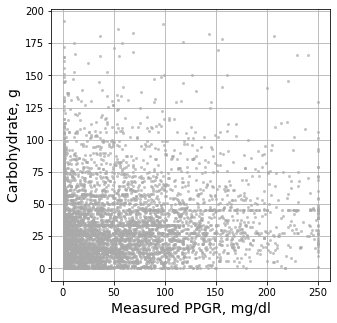

In [308]:
X_path = os.path.join(global_path, 'meal_features_t1d_segata.csv')
X,y = preprocess_X(X_path, control_predictor=False, max_gl=False, without_micr=False)
#del X['RegistrationCode']
predicte_vs_measured = predict_and_estimate(X,y,ylim1=-25, ylim2=200)
predicte_vs_measured.to_csv(os.path.join(global_path, 'predicted_vs_measured_ppgr_complete.csv'))


X1,y1 = preprocess_X(X_path, control_predictor=True, max_gl=False, without_micr=True)
predicte_vs_measured = predict_and_estimate(X1,y1,ylim1=-25, ylim2=200)
predicte_vs_measured.to_csv(os.path.join(global_path, 'predicted_vs_measured_ppgr_baseline_predictor.csv'))

#X1,y1 = preprocess_X(X_path, control_predictor=True, max_gl=False, without_micr=True)
#del X1['BolusInsulinMeal_90_15']
#predicte_vs_measured = predict_and_estimate(X1,y1)
#predicte_vs_measured.to_csv(os.path.join(global_path, 'predicted_vs_measured_ppgr_glucose_carbs_predictor.csv'))



X1,y1 = preprocess_X(X_path, control_predictor=False, max_gl=False, without_micr=True)
do_correl_pearson(y1, X['Carbohydrate_g'],  name2 = 'Carbohydrate, g',name1 = 'Measured PPGR, mg/dl')



look at phenotypes

# prediction of the max gluxose

after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377
r squared 0.36624939808630497
(0.6052770634386272, 0.0)
after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377
r squared 0.1833651512469492
(0.42992082135008025, 2.9264889841265183e-285)
after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377
(0.17219121710150584, 1.247504387701638e-43)


0

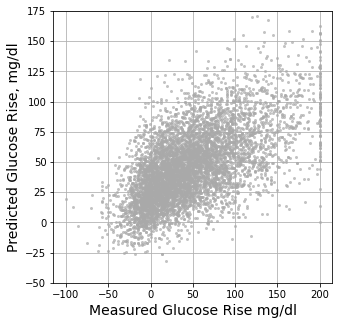

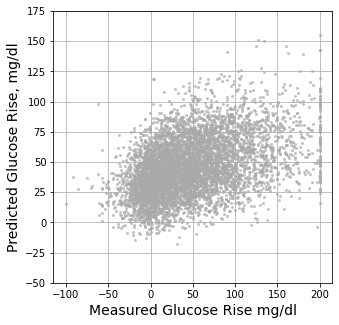

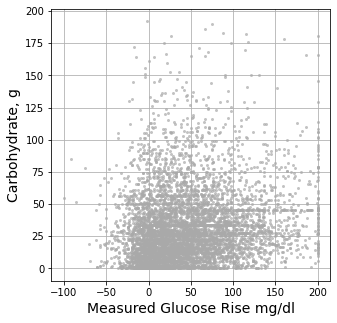

In [309]:
X,y = preprocess_X(X_path, control_predictor=False, max_gl=True, without_micr=False)
del X['RegistrationCode']
predicte_vs_measured = predict_and_estimate(X,y,name1 = 'Measured Glucose Rise mg/dl', 
                                            name2 = 'Predicted Glucose Rise, mg/dl',ylim1=-50, ylim2=175)
predicte_vs_measured.to_csv(os.path.join(global_path, 'predicted_vs_measured_maxglu_complete.csv'))

X1,y1 = preprocess_X(X_path, control_predictor=True, max_gl=True, without_micr=True)
predicte_vs_measured = predict_and_estimate(X1,y1, name1 = 'Measured Glucose Rise mg/dl',
                                            name2 = 'Predicted Glucose Rise, mg/dl', ylim1=-50, ylim2=175)
predicte_vs_measured.to_csv(os.path.join(global_path, 'predicted_vs_measured_maxglu_baseline_predictor.csv'))

X1,y1 = preprocess_X(X_path, control_predictor=False, max_gl=True, without_micr=True)
y1.name='Measured Glucose Rise mg/dl'
do_correl_pearson(y1, X['Carbohydrate_g'],  name2 = 'Carbohydrate, g', name1 = 'Measured Glucose Rise mg/dl')




check without microbiome 

after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377
r squared 0.34897071297252313
(0.5910040369430835, 0.0)
after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377
r squared 0.36779893389546847
(0.6067359343545174, 0.0)


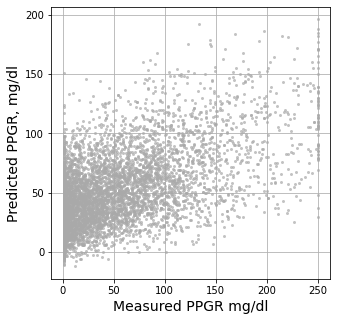

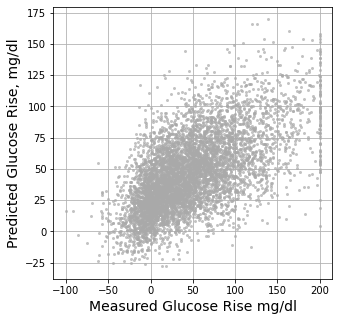

In [310]:
X1,y1 = preprocess_X(X_path, control_predictor=False, max_gl=False, without_micr=True)
predicte_vs_measured = predict_and_estimate(X1,y1)
predicte_vs_measured.to_csv(os.path.join(global_path, 'predicted_vs_measured_ppgr_without_micr.csv'))

X1,y1 = preprocess_X(X_path, control_predictor=False, max_gl=True, without_micr=True)
predicte_vs_measured = predict_and_estimate(X1,y1, name1 = 'Measured Glucose Rise mg/dl',  name2 = 'Predicted Glucose Rise, mg/dl')
predicte_vs_measured.to_csv(os.path.join(global_path, 'predicted_vs_measured_maxglu_without_micr.csv'))


# description of the cohort

In [6]:
X_path = os.path.join(global_path, 'meal_features_t1d_segata.csv')
X1,y1 = preprocess_X(X_path, control_predictor=False, max_gl=False, without_micr=True)
X,y = preprocess_X(X_path, control_predictor=False, max_gl=False, without_micr=False)
X_av = X1.groupby(X1.index.get_level_values(0)).mean()

micr_columns= [col for col in X.columns if 'k__Bacteria' in col or col in ['firm_to_bact_ratio', 'shannon_divercity', 'richness',
       'propionate_producing', 'accetate_producing', 'akkermania', 'alipastes',
       'roseburia', 'eubacterium', 'butirate_producing', 'faecalibacterium',
       'subdoligranulum', 'christensenella'] ]
bt_columns = [col for col in X_av.columns if 'bt__' in col]

insulin_cols = ['InsulinBeforeMeal_60_0',
 'InsulinBeforeMeal_30_15',
 'InsulinBeforeMeal_240_15',
 'InsulinBeforeMeal_120_15',
 'InsulinBeforeMeal_60_15only_bolus',
 'BolusInsulinMeal_90_15']


cgm_columns = ['GlucoseTrend_120','GlucoseTrend_60', 'GlucoseTrend_30', 'SugarAtMealStart', '10P_Glucose', '1P_Glucose','2P_Glucose',
 '5P_Glucose','90P_Glucose', '95P_Glucose','98P_Glucose','99P_Glucose','Max_Glucose','Median_Glucose', 'Min_Glucose']


measurements = ['BMI', 'BodyWeight', 'Height', 'Hips', 'Waist']
    
general = ['Age',  'Gender','desease_duration']

after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377
after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377


In [7]:
complete_stats = pd.DataFrame()
children = X_av[X_av['Age']<18]
adults = X_av[X_av['Age']>=18]

print('adults ', adults.shape[0], 'and chidren', children.shape[0])


stats = X_av[bt_columns].describe().T[['mean', 'std', '25%',  '75%']]
stats_a  =adults[bt_columns].describe().T[['mean', 'std', '25%','75%']]
stats_a = stats_a.rename(columns = {col:col+'_adults' for col in stats_a.columns})
stats_c  =children[bt_columns].describe().T[['mean', 'std', '25%', '75%']]
stats_c = stats_c.rename(columns = {col:col+'_children' for col in stats_c.columns})
all_stats = stats.join(stats_a).join(stats_c)

complete_stats = complete_stats.append(all_stats.round(1)[sorted(all_stats.columns)])
all_stats.round(1)[sorted(all_stats.columns)]

#[['mean', 'std'. '25%', '50%']]



adults  75 and chidren 46


,25%,25%_adults,25%_children,75%,75%_adults,75%_children,mean,mean_adults,mean_children,std,std_adults,std_children
bt__bilirubin,0.4,0.5,0.4,0.8,0.8,0.7,0.7,0.7,0.7,0.5,0.4,0.6
bt__ldl_cholesterol,80.0,83.0,74.8,107.0,114.0,97.5,94.4,99.1,86.5,25.5,27.4,19.6
bt__protein_total,6.9,6.9,6.9,7.9,7.8,64.5,20.8,18.7,24.4,26.6,25.4,28.6
bt__potassium,4.1,4.1,4.2,4.5,4.5,4.5,4.3,4.3,4.3,0.3,0.4,0.3
bt__total_cholesterol,151.0,151.0,155.0,180.2,186.5,175.0,166.5,169.7,161.2,27.7,30.7,21.1
bt__chloride,103.0,102.0,103.0,105.5,105.0,105.8,104.0,103.8,104.3,2.5,2.4,2.7
bt__tsh,1.4,1.3,1.6,2.9,2.5,2.9,2.2,2.0,2.5,1.2,1.2,1.2
bt__alt_gpt,12.8,12.2,13.0,20.0,21.8,17.0,18.5,19.5,16.8,12.1,12.1,11.9
bt__creatinine,0.6,0.7,0.5,0.8,0.8,0.7,0.8,0.8,0.8,0.8,0.1,1.3
bt__sodium,137.0,137.0,137.0,140.0,140.0,139.0,138.0,138.2,137.8,2.4,2.5,2.3


In [8]:
stats = X_av[measurements].describe().T[['mean', 'std', '25%',  '75%']]
stats_a  =adults[measurements].describe().T[['mean', 'std', '25%','75%']]
stats_a = stats_a.rename(columns = {col:col+'_adults' for col in stats_a.columns})
stats_c  =children[measurements].describe().T[['mean', 'std', '25%', '75%']]
stats_c = stats_c.rename(columns = {col:col+'_children' for col in stats_c.columns})
all_stats = stats.join(stats_a).join(stats_c)

complete_stats = complete_stats.append(all_stats.round(1)[sorted(all_stats.columns)])
all_stats.round(1)[sorted(all_stats.columns)]



,25%,25%_adults,25%_children,75%,75%_adults,75%_children,mean,mean_adults,mean_children,std,std_adults,std_children
BMI,20.4,21.7,17.0,26.2,27.2,21.7,23.1,25.1,19.9,4.7,3.9,4.2
BodyWeight,54.0,62.0,32.1,71.8,78.8,59.2,61.9,71.4,46.5,19.4,12.9,18.3
Height,156.3,162.1,134.7,172.0,174.0,164.0,161.2,168.5,149.4,16.8,8.0,20.3
Hips,87.5,95.0,68.1,105.0,108.0,94.8,94.3,101.9,81.9,17.3,10.7,19.0
Waist,70.0,76.5,58.6,82.8,87.0,71.4,76.7,82.8,66.7,14.5,11.4,13.6


In [9]:
stats = X_av[cgm_columns].describe().T[['mean', 'std', '25%',  '75%']]
stats_a  =adults[cgm_columns].describe().T[['mean', 'std', '25%','75%']]
stats_a = stats_a.rename(columns = {col:col+'_adults' for col in stats_a.columns})
stats_c  =children[cgm_columns].describe().T[['mean', 'std', '25%', '75%']]
stats_c = stats_c.rename(columns = {col:col+'_children' for col in stats_c.columns})
all_stats = stats.join(stats_a).join(stats_c)
complete_stats = complete_stats.append(all_stats.round(1)[sorted(all_stats.columns)])
all_stats.round(1)[sorted(all_stats.columns)]

#if col not in micr_columns and col not in bt columns

,25%,25%_adults,25%_children,75%,75%_adults,75%_children,mean,mean_adults,mean_children,std,std_adults,std_children
GlucoseTrend_120,-16.2,-15.3,-19.2,0.4,-0.1,0.9,-8.3,-7.5,-9.5,12.4,12.3,12.7
GlucoseTrend_60,-12.8,-12.2,-14.8,-1.6,-1.8,-1.5,-6.7,-6.4,-7.1,10.5,9.5,12.1
GlucoseTrend_30,-8.1,-6.2,-9.5,0.0,0.1,-0.9,-3.5,-3.1,-4.1,6.5,5.3,8.2
SugarAtMealStart,117.5,114.7,127.5,157.1,151.3,172.8,141.1,133.2,154.0,30.9,25.4,34.9
10P_Glucose,71.0,67.5,74.0,94.0,89.0,101.2,83.6,80.2,89.1,19.1,17.1,21.1
1P_Glucose,42.0,40.0,46.1,60.8,57.5,69.7,53.2,50.6,57.3,12.5,10.8,14.2
2P_Glucose,50.0,46.5,52.2,68.0,64.5,75.0,59.5,56.7,64.1,13.8,12.2,15.0
5P_Glucose,61.0,57.0,62.2,80.0,74.5,89.0,71.2,68.1,76.3,16.3,14.5,18.0
90P_Glucose,196.0,188.5,228.2,259.0,248.5,273.8,231.3,218.9,251.3,50.8,47.9,49.6
95P_Glucose,226.0,210.2,253.0,291.0,274.5,300.5,259.1,245.8,280.8,53.5,51.9,49.3


In [10]:
stats = X_av[general].describe().T[['mean', 'std', '25%',  '75%', '50%']]
stats_a  =adults[general].describe().T[['mean', 'std', '25%','75%', '50%']]
stats_a = stats_a.rename(columns = {col:col+'_adults' for col in stats_a.columns})
stats_c  =children[general].describe().T[['mean', 'std', '25%', '75%', '50%']]
stats_c = stats_c.rename(columns = {col:col+'_children' for col in stats_c.columns})
all_stats = stats.join(stats_a).join(stats_c)
complete_stats = complete_stats.append(all_stats.round(1)[sorted(all_stats.columns)])
all_stats.round(1)[sorted(all_stats.columns)]

,25%,25%_adults,25%_children,50%,50%_adults,50%_children,75%,75%_adults,75%_children,mean,mean_adults,mean_children,std,std_adults,std_children
Age,14.0,21.0,10.0,21.0,26.0,13.0,32.0,41.5,15.0,24.7,32.3,12.1,15.0,14.1,3.7
Gender,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.4,0.4,0.4,0.5,0.5,0.5
desease_duration,4.0,7.5,3.0,8.0,12.0,4.0,15.0,19.5,6.0,11.2,15.1,4.5,10.1,10.7,2.7


a


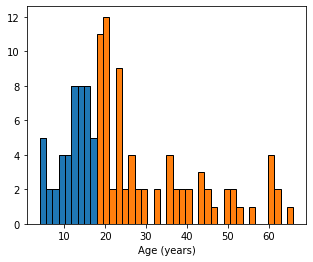

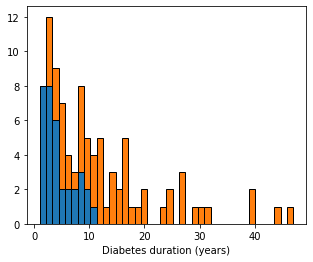

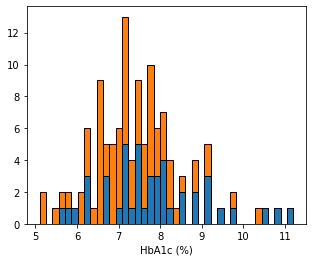

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


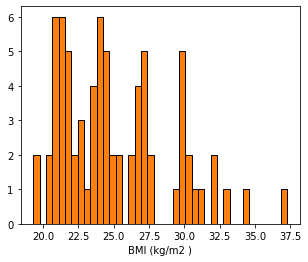

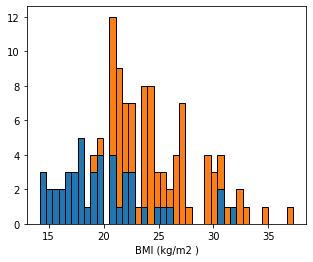

In [11]:
matplotlib.rcParams.update({'font.size': 10})
X_av_kids = X_av[X_av['Age']<18]
X_av_adults= X_av[X_av['Age']>=18]
print('a')
for col in ['Age', 'desease_duration', 'bt__hba1c', 'BMI']:
    if col=='Age':
        col_title = 'Age (years)'
    elif col=='desease_duration':
        col_title = 'Diabetes duration (years)'
    elif col=='bt__hba1c':
        col_title = 'HbA1c (%)'
    elif col=='BMI':
        col_title = 'BMI (kg/m2 )'
        stacked_hist(pd.Series(), X_av_adults[col], col_title)
    stacked_hist(X_av_kids[col], X_av_adults[col], col_title)
    
#Age (years), Diabetes duration (years) BMI (kg/m2 ),  Number of meals used as input for the predictor per participant, Number of logged meals per participnt
#HbA1c (%)    

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


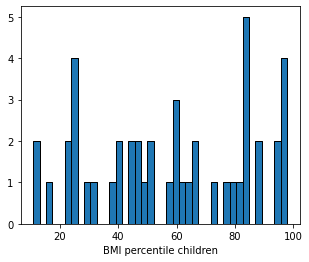

In [12]:
bmi_perc = pd.read_csv(os.path.join(global_path, 'bmi_zsocres_nastya.csv'))

stacked_hist( bmi_perc['bmip'],pd.Series(), 'BMI percentile children')

    #plt.title(title)
plt.show()



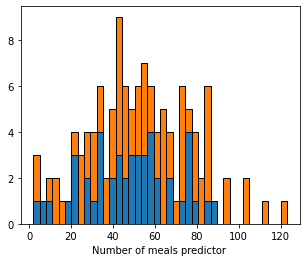

In [13]:
number_of_meals= X.reset_index().groupby('ConnectionID')['MealEventID'].count()

stacked_hist(number_of_meals.loc[X_av_kids.index], number_of_meals.loc[X_av_adults.index], 'Number of meals predictor ')

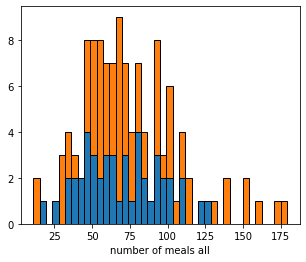

In [14]:
all_foods = pd.read_csv(os.path.join(global_path, 'MealFoodsDF.csv'))

number_of_meals_all= all_foods.groupby('ConnectionID')['MealEventID'].nunique()
stacked_hist(number_of_meals_all.loc[number_of_meals_all.index.isin(X_av_kids.index)], 
                                     number_of_meals_all.loc[number_of_meals_all.index.isin(X_av_adults.index)], 'number of meals all')

In [15]:
pump_type = pd.read_csv(os.path.join(global_path, 'pumps_and_centers.csv')).rename(columns={'Registrant Number':'RegistrationCode'})

X_av = X_av.reset_index().merge(pump_type, on='RegistrationCode').set_index('ConnectionID')

In [16]:
for col in ['Medical center', 'Insulin pump company','CGM company']:
    print(col, 'all', X_av[col].value_counts().to_dict())
    print(col, 'children', X_av[X_av.index.isin(children.index)][col].value_counts().to_dict())
    print(col, 'adults', X_av[X_av.index.isin(adults.index)][col].value_counts().to_dict())

Medical center all {'Sheba': 52, 'Rambam': 39, 'Assaf Harofe': 30}
Medical center children {'Rambam': 17, 'Assaf Harofe': 16, 'Sheba': 13}
Medical center adults {'Sheba': 39, 'Rambam': 22, 'Assaf Harofe': 14}
Insulin pump company all {'Medtronic': 78, 'Omnipod': 24, 'Animas': 18, 'Other': 1}
Insulin pump company children {'Medtronic': 25, 'Omnipod': 15, 'Animas': 6}
Insulin pump company adults {'Medtronic': 53, 'Animas': 12, 'Omnipod': 9, 'Other': 1}
CGM company all {'Libre': 43, 'Medtronic': 42, 'Dexcome': 26, 'Navigator': 8, 'other': 2}
CGM company children {'Medtronic': 18, 'Dexcome': 13, 'Libre': 9, 'Navigator': 5, 'other': 1}
CGM company adults {'Libre': 34, 'Medtronic': 24, 'Dexcome': 13, 'Navigator': 3, 'other': 1}


In [17]:
number_of_meals.name = 'number_of_meals_predictor'

number_of_meals_all.name = 'number_of_meals_all'

nom = pd.DataFrame(number_of_meals).join(number_of_meals_all)

stats = nom.describe().T[['mean', 'std', '25%',  '75%', '50%']]
stats_a  =nom.loc[X_av_adults.index].describe().T[['mean', 'std', '25%','75%', '50%']]
stats_a = stats_a.rename(columns = {col:col+'_adults' for col in stats_a.columns})
stats_c  =nom.loc[X_av_kids.index].describe().T[['mean', 'std', '25%', '75%', '50%']]
stats_c = stats_c.rename(columns = {col:col+'_children' for col in stats_c.columns})
all_stats = stats.join(stats_a).join(stats_c)
complete_stats = complete_stats.append(all_stats.round(1)[sorted(all_stats.columns)])
complete_stats

,25%,25%_adults,25%_children,75%,75%_adults,75%_children,mean,mean_adults,mean_children,std,std_adults,std_children,50%,50%_adults,50%_children
bt__bilirubin,0.4,0.5,0.4,0.8,0.8,0.7,0.7,0.7,0.7,0.5,0.4,0.6,NaN,NaN,NaN
bt__ldl_cholesterol,80.0,83.0,74.8,107.0,114.0,97.5,94.4,99.1,86.5,25.5,27.4,19.6,NaN,NaN,NaN
bt__protein_total,6.9,6.9,6.9,7.9,7.8,64.5,20.8,18.7,24.4,26.6,25.4,28.6,NaN,NaN,NaN
bt__potassium,4.1,4.1,4.2,4.5,4.5,4.5,4.3,4.3,4.3,0.3,0.4,0.3,NaN,NaN,NaN
bt__total_cholesterol,151.0,151.0,155.0,180.2,186.5,175.0,166.5,169.7,161.2,27.7,30.7,21.1,NaN,NaN,NaN
bt__chloride,103.0,102.0,103.0,105.5,105.0,105.8,104.0,103.8,104.3,2.5,2.4,2.7,NaN,NaN,NaN
bt__tsh,1.4,1.3,1.6,2.9,2.5,2.9,2.2,2.0,2.5,1.2,1.2,1.2,NaN,NaN,NaN
bt__alt_gpt,12.8,12.2,13.0,20.0,21.8,17.0,18.5,19.5,16.8,12.1,12.1,11.9,NaN,NaN,NaN
bt__creatinine,0.6,0.7,0.5,0.8,0.8,0.7,0.8,0.8,0.8,0.8,0.1,1.3,NaN,NaN,NaN
bt__sodium,137.0,137.0,137.0,140.0,140.0,139.0,138.0,138.2,137.8,2.4,2.5,2.3,NaN,NaN,NaN


In [18]:
X_av = X_av.join(number_of_meals_all).join(number_of_meals)

In [19]:
complete_stats.to_csv((os.path.join(global_path, 'complete_stats.csv')))

In [20]:
import ternary as ternary
macronutrients = all_foods.groupby('ConnectionID')['Protein_g','TotalLipid_g','Carbohydrate_g','Energy_kcal'].sum()
macronutrients['protein_ratio'] = macronutrients['Protein_g']*4/macronutrients['Energy_kcal']*100
macronutrients['carb_ratio'] = macronutrients['Carbohydrate_g']*4/macronutrients['Energy_kcal']*100
macronutrients['lipid_ratio'] = macronutrients['TotalLipid_g']*9/macronutrients['Energy_kcal']*100
macronutrients = macronutrients.reset_index()
macronutrients['color'] = macronutrients['ConnectionID'].apply(lambda x: 'orange' if x in X_av_kids.index else 'blue')



/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [21]:
categ = pd.read_csv(os.path.join(global_path,'food_categoris.csv')).drop_duplicates('FoodID', keep='last').set_index('FoodID')

categ.head(3)

,FoodCategoryID,FoodCategoryName_eng
FoodID,,
4906,23,Milk and milk products
4907,23,Milk and milk products
4908,23,Milk and milk products


In [22]:
all_foods['category'] = all_foods['FoodID'].apply(lambda x: categ.loc[x, 'FoodCategoryName_eng'] if x in categ.index else 'not defined')

a


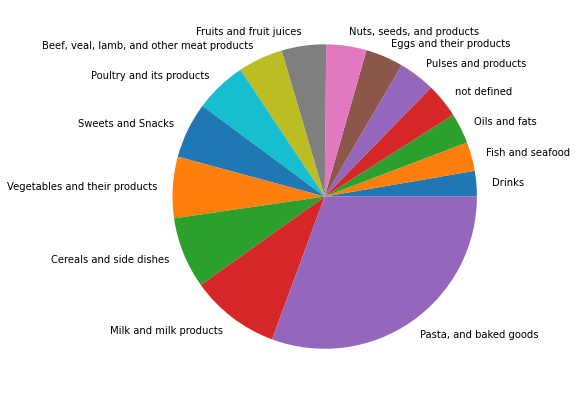

In [23]:
print('a')
rename_cat = {'Non-Kosher Foods':'not defined', 'Snacks (USDA)':'Sweets and Snacks '}

all_foods['category'] =all_foods['category'].apply(lambda x: rename_cat[x] if x in rename_cat.keys()else x)
all_foods_adults  =all_foods[all_foods['ConnectionID'].isin(adults.index)]
energy_cat  =all_foods_adults.groupby('category')['Energy_kcal'].sum().sort_values().tail(15)
energy_cat.name=''
energy_cat.plot.pie(subplots=True,figsize=(10, 7))

plt.show()

a


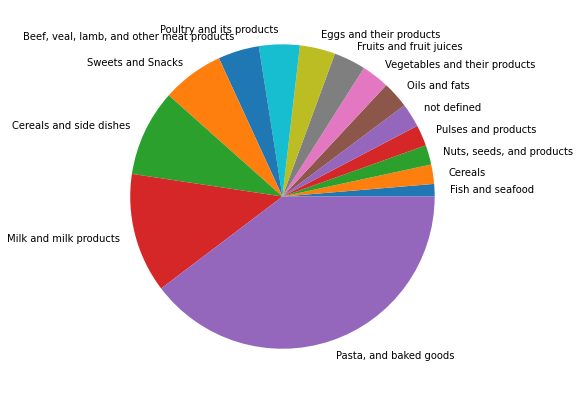

In [24]:
print('a')
rename_cat = {'Non-Kosher Foods':'not defined', 'Snacks (USDA)':'Sweets and Snacks '}

all_foods['category'] =all_foods['category'].apply(lambda x: rename_cat[x] if x in rename_cat.keys()else x)
all_foods_children  =all_foods[all_foods['ConnectionID'].isin(children.index)]
energy_cat  =all_foods_children.groupby('category')['Energy_kcal'].sum().sort_values().tail(15)
energy_cat.name=''
energy_cat.plot.pie(subplots=True,figsize=(10, 7))

plt.show()

a


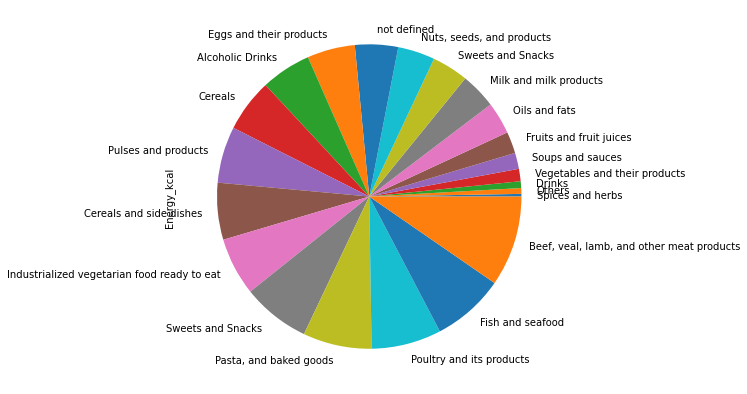

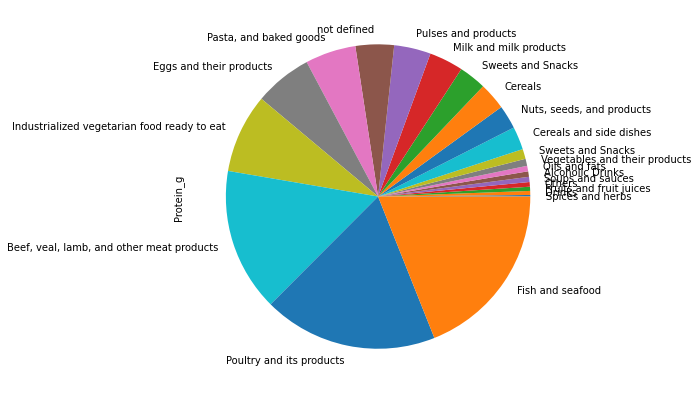

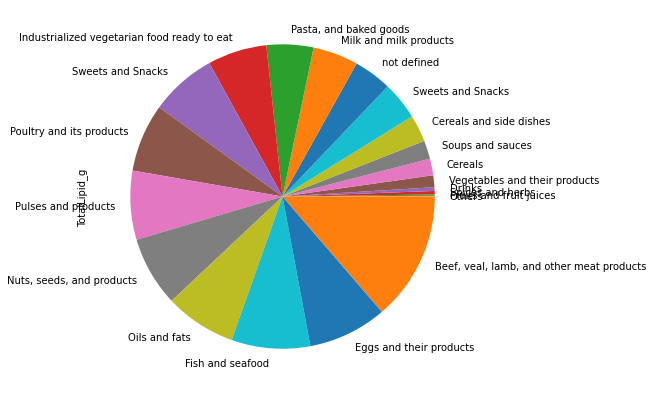

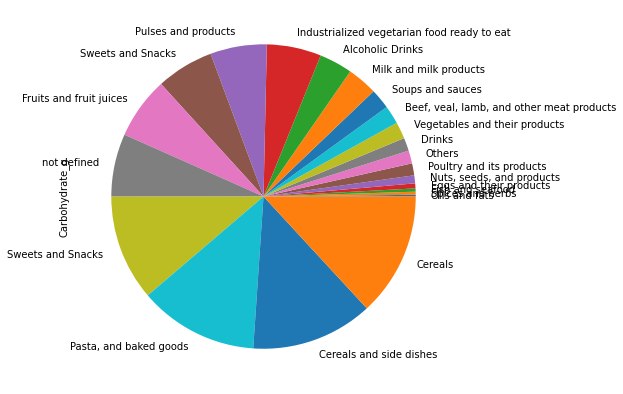

In [25]:
print('a')
energy_cat  =all_foods.groupby('category')['Energy_kcal'].mean().sort_values()

energy_cat.plot.pie(subplots=True,figsize=(10, 7))

plt.show()

protein_cat  =all_foods.groupby('category')['Protein_g'].mean().sort_values()

protein_cat.plot.pie(subplots=True,figsize=(10, 7))

plt.show()

fat_cat  =all_foods.groupby('category')['TotalLipid_g'].mean().sort_values()

fat_cat.plot.pie(subplots=True,figsize=(10, 7))

plt.show()

carb_cat  =all_foods.groupby('category')['Carbohydrate_g'].mean().sort_values()

carb_cat.plot.pie(subplots=True,figsize=(10, 7))

plt.show()

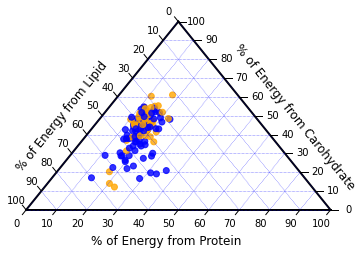

In [26]:
import ternary
    
scale = 100
figure, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=10)
fontsize = 12
offset = 0.14
#tax.set_title("Macrnutrient Intake", fontsize=fontsize)
#tax.right_corner_label("X", fontsize=fontsize)
#tax.top_corner_label("Y", fontsize=fontsize)
#tax.left_corner_label("Z", fontsize=fontsize)
tax.left_axis_label("% of Energy from Lipid", fontsize=fontsize, offset=offset)
tax.right_axis_label("% of Energy from Carohydrate", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("% of Energy from Protein", fontsize=fontsize, offset=offset)
 # Draw lines parallel to the axes
tax.scatter(macronutrients[['protein_ratio', 'carb_ratio', 'lipid_ratio']].values, color = macronutrients['color'].values, alpha=0.8)
    
tax.ticks(axis='lrb', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()

compare with microbiome

after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377
shape!!! (134,)
shape!!! (134,)
shape!!! (134,)
shape!!! (134,)
shape!!! (134,)
shape!!! (134,)
shape!!! (134,)
shape!!! (134,)
shape!!! (134,)
shape!!! (134,)
shape!!! (134,)
shape!!! (134,)
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp|fSGB__1439|gSGB__3529|sSGB__4716 0.04887813776760634
k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales|f__Acidaminococcaceae|g__Phascolarctobacterium|s__Phascolarctobacterium_sp_CAG_207|fSGB__1704|gSGB__4258|sSGB__5792 0.09320530504776757
shape!!! (134,)
shape!!! (134,)
shape!!! (134,)
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_sp|fSGB__1449|gSGB__3596|sSGB__4826 0.09637

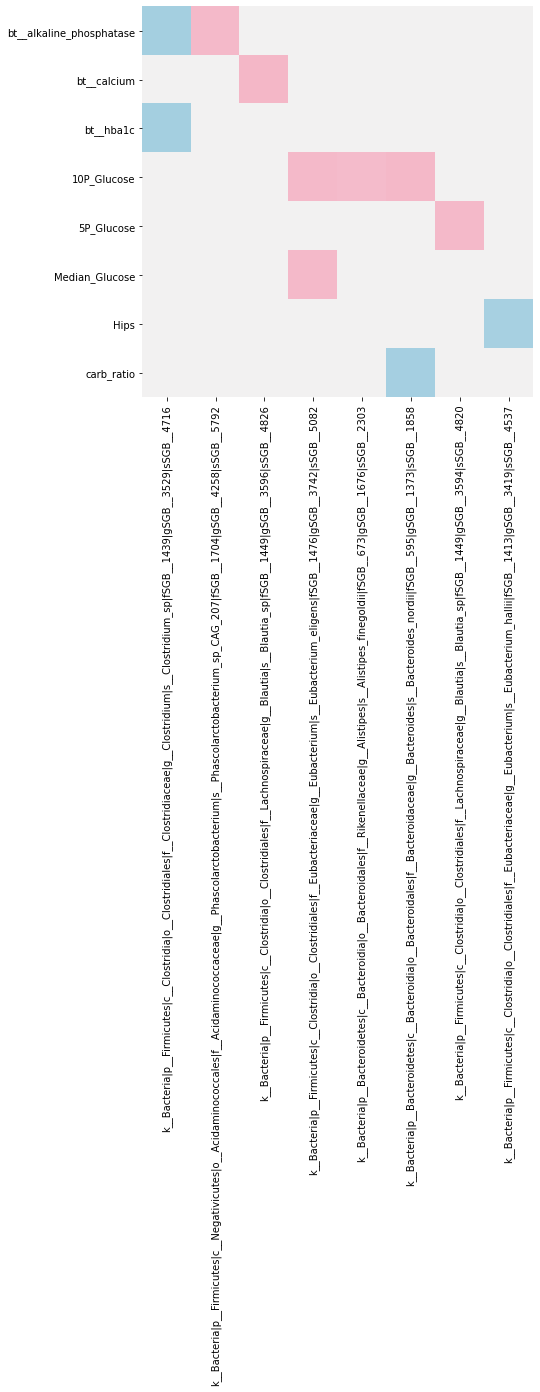

In [28]:
cols_to_match_microbiome = bt_columns+['10P_Glucose', '1P_Glucose','2P_Glucose',\
 '5P_Glucose','90P_Glucose', '95P_Glucose','98P_Glucose','99P_Glucose','Max_Glucose','Median_Glucose', 'Min_Glucose']+\
measurements+['Age', 'desease_duration']

X3,y3 = preprocess_X(X_path, control_predictor=False, max_gl=True, without_micr=False)


X_micr= X3.groupby(X3.index.get_level_values(0)).mean()[micr_columns].sort_index()
X_to_match= X3.groupby(X3.index.get_level_values(0))[cols_to_match_microbiome].mean().dropna().sort_index()
X_to_match = X_to_match.join(macronutrients.set_index('ConnectionID'))
del X_to_match['color']
def rename_bact_name(col):
    return col
do_a_heatmap_and_corr_matrix(X_micr,X_to_match )

Shap and feature importance

In [311]:
X,y = preprocess_X(X_path, control_predictor=False, max_gl=False, without_micr=False)
model = xgboost.XGBRegressor(learning_rate = 0.005, n_estimators = 3000, reg_lambda = 10, subsample = 0.75, \
                                        colsample_bytree = 0.4, max_depth = 60, reg_alpha = 10, min_child_weight = 50, nthread = 4, seed = 5)
del X['RegistrationCode']

X = X[X.index.isin(y.index)].sort_index()
y = y[y.index.isin(X.index)].sort_index()
fitted = model.fit(X, y)

after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377


In [312]:
#X = X.rename(columns = {x:bacteria_name(x) for x in X.columns})

In [313]:
shap_values = shap.TreeExplainer(fitted).shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [314]:
def get_shap_categories(shap_values, features, features_categories, feat_col, cat_col):
    """
    Group shap values into feature category groups
    
    Parameters
    ----------
    shap_values: SHAP values numpy array
    features: pandas dataframe of X
    features_categories: a pandas df that contains feature names in feat_col and categories in cat_col
    feat_col: name of column with features names
    cat_col: name of column withcategories names
    
                
    Returns
    -------
    shap_values_cats: pandas df with grouped shap values into feature category groups
    
    """
    # Make shap_values a Dataframe with named columns
    shap_values = pd.DataFrame(data=shap_values, columns=features.columns)
    
    # retain only relevant columns in feature_categories
    features_categories = features_categories[features_categories[feat_col].isin(features.columns)]
    
    shap_values_cats = pd.DataFrame(index=shap_values.index)
    for cat_val in features_categories[cat_col].unique():
        cols = list(features_categories.loc[features_categories[cat_col]==cat_val,feat_col])
        shap_values_cats.loc[:,cat_val] = shap_values[cols].sum(axis=1)
    
#     shap_values_mean_abs = shap_values_cats_df.abs().mean().sort_values(ascending=False).to_frame().reset_index()
#     shap_values_mean_abs.columns = ['Feature category', 'Mean absolute SHAP']
    
    return shap_values_cats

def plot_shap_summary_bar(shap_values_df, ax=None, sz=14):
    """
    Plot bar plot of mean abosulute SHAP values
    
    Parameters
    ----------
    shap_values_df: pandas dataframe of SHAP values
    ax: matplotlib axes
    sz: size for fonts   
                
    Returns
    -------
    ax: matplotlib axes
    
    from @hagai_rossman
    
    """
    data = shap_values_df.abs().mean(axis=0).reset_index()
    data.columns = ['Feature category', 'Mean absolute SHAP']
    data.sort_values('Mean absolute SHAP', ascending=False, inplace=True)
    
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(10,len(data)//2))
        
    sns.barplot(y='Feature category', x='Mean absolute SHAP',data=data, color=sns.color_palette('coolwarm')[0], ax=ax)

    axis_color='#333333'
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(bottom=True, left=False)
    ax.tick_params('x', labelsize=sz)
    ax.tick_params('y', labelsize=sz)
    ax.set_ylabel('')
    ax.set_xlabel('Mean absolute Shapely value', fontsize=sz)
    plt.show()
    return ax

In [57]:
#micr_columns,bt_columns,general,measurements,cgm_columns,insulin_cols

time_feat = ['Exercise_timeToLast',  'TimeOfTheDat']

foods = [col for col in X.columns   if col[-2:]=='_g' or col[-3:]=='_mg'  or col == 'Carbs/Fat' 
        or col in ['VitaminD_IU', 'Energy_kcal']]


insulin_cols = [col for col in X.columns   if 'Insulin' in col]
#'Exercise_timeToLast', 'Exercise_timeToNext', 'TimeOfTheDat'


remaining = [col for col in X.columns  if col not in cgm_columns and col not in micr_columns
             and col not in bt_columns
             and col not in general
             and col not in measurements
             and col not in insulin_cols and col not in time_feat
            and col not in foods]
feature_groups = pd.DataFrame(columns = ['group_name', 'feat_name'])

j = 0
for i in range(len(bt_columns)):
    feature_groups.loc[j+i, ['group_name', 'feat_name']]= ['Baseline Laborotory Data', bt_columns[i]]
    j=j+1
    
for i in range(len(general)):
    feature_groups.loc[j+i, ['group_name', 'feat_name']]= ['Demographics', general[i]]
    j=j+1


for i in range(len(measurements)):
    feature_groups.loc[j+i, ['group_name', 'feat_name']]= ['Antropometrics', measurements[i]]
    j=j+1
    
for i in range(len(time_feat)):
    feature_groups.loc[j+i, ['group_name', 'feat_name']]= ['Routine', time_feat[i]]
    j=j+1
    
for i in range(len(insulin_cols)):
    feature_groups.loc[j+i, ['group_name', 'feat_name']]= ['Insulin', insulin_cols[i]]
    j=j+1
    
for i in range(len(cgm_columns)):
    feature_groups.loc[j+i, ['group_name', 'feat_name']]= ['CGM', cgm_columns[i]]
    j=j+1
    
for i in range(len(micr_columns)):
    if 'SGB' in micr_columns[i]:
        feature_groups.loc[j+i, ['group_name', 'feat_name']]= ['Microbiome', micr_columns[i]]
        j=j+1
    
for i in range(len(foods)):
    feature_groups.loc[j+i, ['group_name', 'feat_name']]= ['Nutrients', foods[i]]
    j=j+1
    
#for i in range(len(remaining)):
#    feature_groups.loc[j+i, ['group_name', 'feat_name']]= ['Microbiome transformed', remaining[i]]
#    j=j+1
    

shap_categoris = get_shap_categories(shap_values, X, feature_groups, 'feat_name', 'group_name')  
import seaborn as sns
plot_shap_summary_bar(shap_categoris)


NameError: name 'get_shap_categories' is not defined

In [319]:
def rename_columns(col):
    if col == 'SugarAtMealStart':
        return 'Glucose at Meal Initiation'
    elif col == 'TimeOfTheDat':
        return 'Time Of The Day'
    else:
        return bacteria_name(col).replace('_', ' ').replace('normed', '').replace(' 15','')

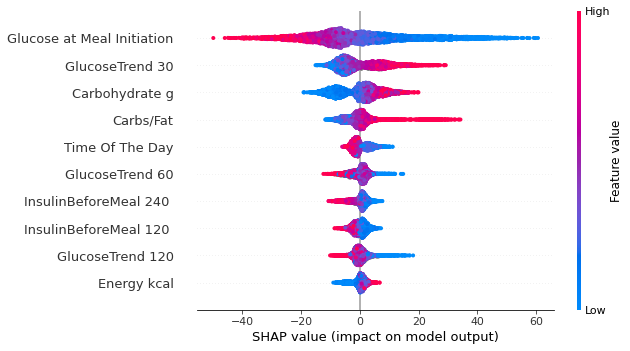

In [320]:
import matplotlib

plt.rcParams['figure.figsize'] = [8, 6]

font = {'family' : 'normal', 'weight' : 'normal', 'size' : 50} 
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rc('font', **font)

X1 = X.rename(columns = {col:rename_columns(col) for col in X.columns})
#shap_values = shap.TreeExplainer(fitted).shap_values(X1)
shap.summary_plot(shap_values, X1, max_display=10)

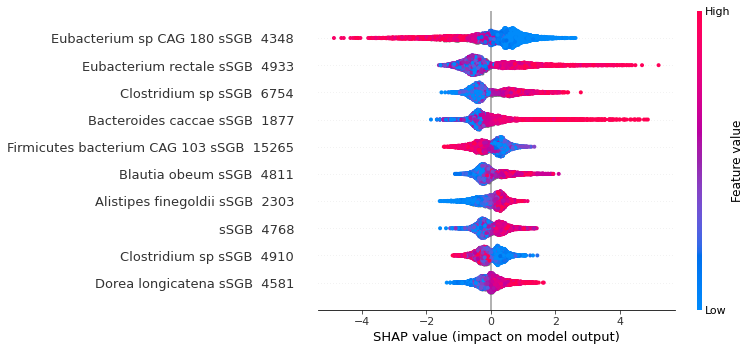

In [318]:
species = [col for col in X1.columns if 'SGB' in col]
species_f = ['SGB' in col for col in X1.columns]
shap_values_n = [a[species_f] for a in shap_values]

shap.summary_plot(np.array(shap_values_n), X1[species], max_display=10)



#shap.summary_plot(shap_values, X1, max_display=10)

In [195]:
#children.loc[5905, 'Gender']=1
#children.loc[5419, 'BodyWeight']=64.5
#children.loc[5419, 'Height']=170.5
#children.loc[5419, 'BMI'] = 22.318339
children[['Age', 'BMI', 'Gender', 'BodyWeight', 'Height']].to_csv(os.path.join(global_path, 'children_stats.csv'))

In [29]:
insulin = pd.read_pickle('/net/mraid08/export/jafar/Microbiome/Analyses/PNP3/DFOut//InsulinDF_bolus.dat')

In [30]:
X_to_check = pd.read_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/predictor/meal_features_t1d.csv').set_index(['ConnectionID', 'MealEventID'])


In [31]:
ind_pers = insulin['InsulinValue'].loc[conn]

ind_pers = ind_pers[ind_pers.index>time]
ind_pers = ind_pers[ind_pers.index<time+timedelta(minutes=15)]

NameError: name 'conn' is not defined

In [ ]:
insulin_feat = X[['InsulinBeforeMeal_60_0',
 'InsulinBeforeMeal_30_15',
 'InsulinBeforeMeal_240_15',
 'InsulinBeforeMeal_120_15',
 'InsulinBeforeMeal_90_15only_bolus',
 'InsulinBeforeMeal_60_15only_bolus',
 'BolusInsulinMeal_90_15']]

In [173]:
X,y = preprocess_X(X_path, control_predictor=False, max_gl=False, without_micr=False)
insulin_feat = X[['InsulinBeforeMeal_30_15',
 'InsulinBeforeMeal_240_15',
 'InsulinBeforeMeal_120_15',
 'InsulinBeforeMeal_90_15only_bolus',
 'InsulinBeforeMeal_60_15only_bolus',
 'BolusInsulinMeal_90_15']]


X_to_check['Timestamp']
from datetime import timedelta
wrong_bolus = pd.DataFrame(index =X.index , columns = ['Bolus_15', ''])


for ind in X.index:
    conn = ind[0]
    time = pd.to_datetime(X_to_check.loc[ind, 'Timestamp'])
    ind_pers = insulin['InsulinValue'].loc[conn]
    ind_pers = ind_pers[ind_pers.index>time+timedelta(minutes=1)]
    ind_pers = ind_pers[ind_pers.index<time+timedelta(minutes=15)]
    if ind_pers.shape[0]>0:
        insulin_feat.loc[ind, 'bolus_extra'] = ind_pers.max()
    else:
        insulin_feat.loc[ind, 'bolus_extra'] =0
        
for col in ['InsulinBeforeMeal_30_15',
 'InsulinBeforeMeal_240_15',
 'InsulinBeforeMeal_120_15',
 'InsulinBeforeMeal_90_15only_bolus',
 'InsulinBeforeMeal_60_15only_bolus',
 'BolusInsulinMeal_90_15']:
    X[col] = X[col]-insulin_feat['bolus_extra']    
    

after merging and crowd filtering 6871
after removing with 15 gr of carbs and bolus less than 0.1 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

r squared 0.341614437166352
(0.5844956994761102, 0.0)


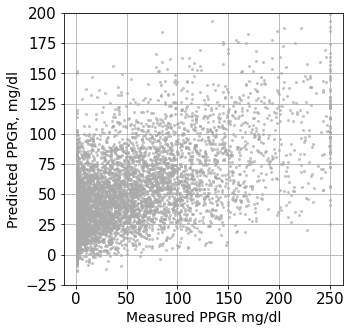

In [177]:
predicte_vs_measured = predict_and_estimate(X,y,ylim1=-25, ylim2=200)

In [33]:
X_chec

Conn_start            Timestamp
ConnectionID MealEventID                                          
2866         212819.0     2017-10-11 10:04:53  2017-10-11 10:04:53
             212872.0     2017-10-11 10:04:53  2017-10-11 12:39:40
             212986.0     2017-10-11 10:04:53  2017-10-11 20:54:00
             213207.0     2017-10-11 10:04:53  2017-10-12 11:37:25
             215309.0     2017-10-11 10:04:53  2017-10-18 14:07:41
...                                       ...                  ...
5943         377864.0     2018-07-04 13:31:46  2018-07-16 21:44:56
             378675.0     2018-07-04 13:31:46  2018-07-17 10:00:26
             378678.0     2018-07-04 13:31:46  2018-07-17 14:41:13
             378683.0     2018-07-04 13:31:46  2018-07-17 18:32:39
             378686.0     2018-07-04 13:31:46  2018-07-17 22:05:57

[6486 rows x 2 columns]

In [34]:

start= X_chec.groupby(X_chec.index.get_level_values(0))['Timestamp'].min()
start.name = 'Conn_start'
#X_chec = X_chec.join(start)[['Conn_start', 'Timestamp']]
X_chec[pd.to_datetime(X_chec['Timestamp'])<pd.to_datetime(X_chec['Conn_start'])+timedelta(days=15)]

Conn_start            Timestamp
ConnectionID MealEventID                                          
2866         212819.0     2017-10-11 10:04:53  2017-10-11 10:04:53
             212872.0     2017-10-11 10:04:53  2017-10-11 12:39:40
             212986.0     2017-10-11 10:04:53  2017-10-11 20:54:00
             213207.0     2017-10-11 10:04:53  2017-10-12 11:37:25
             215309.0     2017-10-11 10:04:53  2017-10-18 14:07:41
...                                       ...                  ...
5943         377864.0     2018-07-04 13:31:46  2018-07-16 21:44:56
             378675.0     2018-07-04 13:31:46  2018-07-17 10:00:26
             378678.0     2018-07-04 13:31:46  2018-07-17 14:41:13
             378683.0     2018-07-04 13:31:46  2018-07-17 18:32:39
             378686.0     2018-07-04 13:31:46  2018-07-17 22:05:57

[6377 rows x 2 columns]

In [35]:
from DataLoaders.CGMLoader import CGMLoader
def time_in_good_range(one):
    return one[one>70][one<180].shape[0]/one.shape[0]

cgml=CGMLoader()
cgmld = cgml.get_data(study_ids = [6]).df.reset_index()
cgmld['ConnectionID'] = cgmld['ConnectionID'].astype(int)
cgmld = cgmld.set_index(['ConnectionID', 'Date']).join(start).reset_index()
cgmld = cgmld[pd.to_datetime(cgmld['Date'])<pd.to_datetime(cgmld['Conn_start'])+timedelta(days=15)]
cgmld = cgmld[pd.to_datetime(cgmld['Date'])>pd.to_datetime(cgmld['Conn_start'])-timedelta(days=1)]
cgmld['Day']  = cgmld['Date'].astype(str).str[:10]
cgmld


,ConnectionID,Date,RegistrationCode,GlucoseValue,PPGR,Conn_start,Day
0,3555,2018-01-25 00:06:00,2010578,286.0,46.875000,2018-01-24 10:42:50,2018-01-25
1,3555,2018-01-25 00:11:00,2010578,300.0,20.333333,2018-01-24 10:42:50,2018-01-25
2,3555,2018-01-25 00:16:00,2010578,309.0,2.333333,2018-01-24 10:42:50,2018-01-25
3,3555,2018-01-25 00:21:00,2010578,318.0,0.000000,2018-01-24 10:42:50,2018-01-25
4,3555,2018-01-25 00:26:00,2010578,321.0,0.000000,2018-01-24 10:42:50,2018-01-25
...,...,...,...,...,...,...,...
832011,4455,2018-07-24 07:10:00,2998285,130.0,NaN,2018-07-10 13:58:53,2018-07-24
832012,4455,2018-07-24 07:25:00,2998285,120.0,NaN,2018-07-10 13:58:53,2018-07-24
832013,4455,2018-07-24 07:40:00,2998285,112.0,NaN,2018-07-10 13:58:53,2018-07-24
832014,4455,2018-07-24 07:55:00,2998285,106.0,NaN,2018-07-10 13:58:53,2018-07-24


In [36]:
print(cgmld.groupby('ConnectionID')['Day'].nunique().sum())
print(cgmld.groupby('ConnectionID')['Day'].nunique().mean())
print(cgmld.groupby('ConnectionID')['Day'].nunique().std())

print(cgmld[cgmld['ConnectionID'].isin(adults.index)].groupby('ConnectionID')['Day'].nunique().mean())
print(cgmld[cgmld['ConnectionID'].isin(adults.index)].groupby('ConnectionID')['Day'].nunique().std())

print(cgmld[cgmld['ConnectionID'].isin(children.index)].groupby('ConnectionID')['Day'].nunique().mean())
print(cgmld[cgmld['ConnectionID'].isin(children.index)].groupby('ConnectionID')['Day'].nunique().std())

1775
14.791666666666666
2.0534694287176207
14.824324324324325
1.9539780856310156
14.73913043478261
2.2254565834522406


In [37]:
from DataLoaders.CGMLoader import CGMLoader
def time_in_good_range(one):
    return one[one>70][one<180].shape[0]/one.shape[0]

cgml=CGMLoader()
cgmld = cgml.get_data(study_ids = [6]).df

cgm_features  = pd.DataFrame()

cgm_features['average'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].mean()
cgm_features['noise'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].std()
cgm_features['variability'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].std()/cgmld.groupby(level='RegistrationCode')['GlucoseValue'].mean()
cgm_features['ppgr_95p'] = cgmld.groupby(level='RegistrationCode')['PPGR'].quantile(0.95)
cgm_features['time_in_good_range'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].apply(time_in_good_range)

In [38]:
X_all = pd.read_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/predictor/meal_features_t1d.csv')
start= X_all.groupby(X_all.index.get_level_values(0))['Timestamp'].min()
start.name = 'Conn_start'
X_all = X_all.join(start)
X_all = X_all[pd.to_datetime(X_all['Timestamp'])<pd.to_datetime(X_all['Conn_start'])+timedelta(days=15)]
print('after removing meals that are more than 15 days after the first', X.shape[0])
X_all['Day'] = X_all['Timestamp'].str[:10]

after removing meals that are more than 15 days after the first 6377


In [39]:
X_all = X_all.reset_index()
print(X_all.groupby('ConnectionID')['Day'].nunique().sum())
print(X_all.groupby('ConnectionID')['Day'].nunique().mean())
print(X_all.groupby('ConnectionID')['Day'].nunique().std())

print(X_all[X_all['ConnectionID'].isin(adults.index)].groupby('ConnectionID')['Day'].nunique().mean())
print(X_all[X_all['ConnectionID'].isin(adults.index)].groupby('ConnectionID')['Day'].nunique().std())

print(X_all[X_all['ConnectionID'].isin(children.index)].groupby('ConnectionID')['Day'].nunique().mean())
print(X_all[X_all['ConnectionID'].isin(children.index)].groupby('ConnectionID')['Day'].nunique().std())

1566
12.942148760330578
3.2616394667435706
12.96
3.1854398482826554
12.91304347826087
3.417771118768759


In [40]:

print(all_foods.groupby('ConnectionID')['MealEventID'].nunique().sum())
print(all_foods.groupby('ConnectionID')['MealEventID'].nunique().mean())
print(all_foods.groupby('ConnectionID')['MealEventID'].nunique().std())

print(all_foods[all_foods['ConnectionID'].isin(adults.index)].groupby('ConnectionID')['MealEventID'].nunique().mean())
print(X_all[X_all['ConnectionID'].isin(adults.index)].groupby('ConnectionID')['MealEventID'].nunique().std())

print(all_foods[all_foods['ConnectionID'].isin(children.index)].groupby('ConnectionID')['MealEventID'].nunique().mean())
print(all_foods[all_foods['ConnectionID'].isin(children.index)].groupby('ConnectionID')['MealEventID'].nunique().std())



9139
72.53174603174604
32.28614229242918
76.9054054054054
27.34728275119621
69.04347826086956
26.200047940362527


In [41]:
print(macronutrients['protein_ratio'].mean().mean())
print(macronutrients['protein_ratio'].std())

print(macronutrients[macronutrients['ConnectionID'].isin(adults.index)]['protein_ratio'].mean())
print(macronutrients[macronutrients['ConnectionID'].isin(adults.index)]['protein_ratio'].std())

print(macronutrients[macronutrients['ConnectionID'].isin(children.index)]['protein_ratio'].mean())
print(macronutrients[macronutrients['ConnectionID'].isin(children.index)]['protein_ratio'].std())


17.124196009536693
4.395747163576842
17.525951825196127
4.811777250675253
16.21425947656676
3.30181932772019


In [42]:
print(macronutrients['carb_ratio'].mean().mean())
print(macronutrients['carb_ratio'].std())

print(macronutrients[macronutrients['ConnectionID'].isin(adults.index)]['carb_ratio'].mean())
print(macronutrients[macronutrients['ConnectionID'].isin(adults.index)]['carb_ratio'].std())

print(macronutrients[macronutrients['ConnectionID'].isin(children.index)]['carb_ratio'].mean())
print(macronutrients[macronutrients['ConnectionID'].isin(children.index)]['carb_ratio'].std())

41.64340653372347
10.241668876433433
39.557968887716285
9.847837479165364
45.16514299454061
10.008710598405063


In [43]:
print(macronutrients['lipid_ratio'].mean().mean())
print(macronutrients['lipid_ratio'].std())

print(macronutrients[macronutrients['ConnectionID'].isin(adults.index)]['lipid_ratio'].mean())
print(macronutrients[macronutrients['ConnectionID'].isin(adults.index)]['lipid_ratio'].std())

print(macronutrients[macronutrients['ConnectionID'].isin(children.index)]['lipid_ratio'].mean())
print(macronutrients[macronutrients['ConnectionID'].isin(children.index)]['lipid_ratio'].std())

39.06466090473616
7.97299705701951
40.314611853114585
7.593643949421224
37.10214260874437
8.458810290746525


In [44]:
from DataLoaders import DietLoggingLoader
dll = DietLoggingLoader.DietLoggingLoader()

dlld = dll.get_data(study_ids=6)


log = dll.add_nutrients(dlld.df, nutrient_list=['energy_kcal', 'carbohydrate_g', 'protein_g', 'totallipid_g'])
log.head(3)


weight unit_id meal_type score  \
RegistrationCode Date                food_id                                   
2010578          2018-01-24 10:42:50 8723      300.0      49      Meal   NaN   
                 2018-01-24 11:26:00 11400      20.0     NaN     Other   NaN   
                 2018-01-24 14:49:00 8311       17.0     NaN     Other   NaN   

                                              energy_kcal  carbohydrate_g  \
RegistrationCode Date                food_id                                
2010578          2018-01-24 10:42:50 8723        141.3759         8.80995   
                 2018-01-24 11:26:00 11400        37.4000         4.72000   
                 2018-01-24 14:49:00 8311         94.1800         9.09500   

                                              protein_g  totallipid_g  
RegistrationCode Date                food_id                           
2010578          2018-01-24 10:42:50 8723      2.367099      10.68453  
                 2018-01-24 11:26:00 11400     0.720000       1.74000  
                 2018-01-24 14:49:00 8311      0.680000       5.78000

In [45]:
cgmld_mean = cgmld.groupby(['RegistrationCode', 'Day'])['GlucoseValue', 'ConnectionID'].mean()

KeyError: 'Day'

In [46]:
log = log.reset_index()
log['Day']  = log['Date'].astype(str).str[:10]

log = log.groupby(['RegistrationCode', 'Day'])[['energy_kcal', 'carbohydrate_g', 'protein_g', 'totallipid_g']].sum()

#log = log[log.index.isin(cgmld_mean.index)]

log

energy_kcal  carbohydrate_g  protein_g  \
RegistrationCode Day                                                  
2010578          2018-01-24   561.922460       61.006430  12.443136   
                 2018-01-25   553.695250       98.862658  13.101924   
                 2018-01-26   473.893450       55.218035  12.896572   
                 2018-01-27   417.308500       49.809720  11.846590   
                 2018-01-28   362.820510       70.252965  15.519555   
...                                  ...             ...        ...   
2998285          2018-07-19   965.357950      112.697175  40.361649   
                 2018-07-20  1663.817820      147.774000  87.625021   
                 2018-07-21  1354.636618      153.711309  56.429768   
                 2018-07-22   452.430000       62.650500  22.394100   
                 2018-07-23  1316.827620      142.703807  50.103101   

                             totallipid_g  
RegistrationCode Day                       
2010578          2018-01-24     29.008482  
                 2018-01-25     11.924817  
                 2018-01-26     23.075905  
                 2018-01-27     18.739470  
                 2018-01-28      3.676371  
...                                   ...  
2998285          2018-07-19     38.553165  
                 2018-07-20     74.749623  
                 2018-07-21     52.941822  
                 2018-07-22      9.948200  
                 2018-07-23     63.149602  

[2136 rows x 4 columns]

In [47]:
log = log.reset_index()
log['RegistrationCode'] = log['RegistrationCode'].astype(float)


print(log.groupby('RegistrationCode')['energy_kcal'].mean().mean())
print(log.groupby('RegistrationCode')['energy_kcal'].mean().std())

print(log[log['RegistrationCode'].isin(adults['RegistrationCode'].values)].groupby('RegistrationCode')['energy_kcal'].mean().mean())
print(log[log['RegistrationCode'].isin(adults['RegistrationCode'].values)].groupby('RegistrationCode')['energy_kcal'].mean().std())

print(log[log['RegistrationCode'].isin(children['RegistrationCode'].values)].groupby('RegistrationCode')['energy_kcal'].mean().mean())
print(log[log['RegistrationCode'].isin(children['RegistrationCode'].values)].groupby('RegistrationCode')['energy_kcal'].mean().std())


1452.048686291496
548.2580608612105
1521.6379910433739
519.3645274342273
1406.8913480318158
579.3078465721873


In [48]:
log['energy_kcal'].sum()

3099181.349919671

In [49]:
X['Energy_kcal'].sum()

1899981.08

In [50]:
def time_in_hypo(one):
    return one[one<70].shape[0]/one.shape[0]

def time_in_hyper(one):
    return one[one>180].shape[0]/one.shape[0]


cgm_features  = pd.DataFrame()
cgmld = cgmld.reset_index()
cgmld['RegistrationCode'] = cgmld['RegistrationCode'].astype(float)
cgmld = cgmld.set_index(['RegistrationCode', 'Date'])

cgm_features['average'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].mean()
cgm_features['noise'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].std()
cgm_features['variability'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].std()/cgmld.groupby(level='RegistrationCode')['GlucoseValue'].mean()
cgm_features['ppgr_95p'] = cgmld.groupby(level='RegistrationCode')['PPGR'].quantile(0.95)
cgm_features['time_in_good_range'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].apply(time_in_good_range)
cgm_features['time_in_hyper'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].apply(time_in_hyper)
cgm_features['time_in_hypo'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].apply(time_in_hypo)

In [51]:
cgm_features = X_av.reset_index().set_index('RegistrationCode').join(cgm_features)


In [58]:
cgm_features = cgm_features[[col for col in cgm_features.columns if col not in foods and 'Insulin' not in col 
                             and 'GlucoseTrend' not in col and 'P_Glucose' not in col]]

In [59]:
log = log.reset_index().groupby('RegistrationCode')[['energy_kcal','carbohydrate_g','protein_g','totallipid_g']].sum()


In [60]:
log = log.reset_index()
log['RegistrationCode'] = log['RegistrationCode'].astype(float)
log['carb_ratio'] = log['carbohydrate_g']/ log['energy_kcal']*400
log['protein_ratio'] = log['protein_g']/ log['energy_kcal']*400
log['lipid_ratio'] = log['totallipid_g']/ log['energy_kcal']*400

cgm_features = cgm_features.join(log.set_index('RegistrationCode')[['carb_ratio','protein_ratio','lipid_ratio' ]])


In [61]:
import string

excl_columns = ['Exercise_timeToLast', 'SugarAtMealStart', 'TimeOfTheDat', 
       'GeneSetMap_Perc', 'HGMapped_perc', 'IsGenotek', 'PostQC', 'HasMG',
       'k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__1292|gSGB__3109|sSGB__4121',
       'k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__1443|gSGB__3564|sSGB__4767',
       'k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__1443|gSGB__3565|sSGB__4768',
       'k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__2377|gSGB__6516|sSGB__9203',
       'k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__2834|gSGB__9063|sSGB__13982',
       'k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__2834|gSGB__9064|sSGB__13983',
       'k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__2953|gSGB__9295|sSGB__14252',
       'k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__2954|gSGB__9296|sSGB__14253',
       'k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__3005|gSGB__9468|sSGB__14861',
       'k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__3038|gSGB__9534|sSGB__14937',
       'k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__3059|gSGB__9744|sSGB__15350',
       'k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__3062|gSGB__9747|sSGB__15356',
       'k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__3069|gSGB__9767|sSGB__15385',
               'Median_Glucose']


pers_feat = cgm_features[[col for col in cgm_features.columns if col not in excl_columns]]

def rename_column_phen(col):
    rename_phen = {'age':'Age','bt__hba1c':'HbA1c', 'average':'Glucose - average','noise':'Glucose- sd','ppgr_95p':'PPGR- 95%',\
                'bt__hdl_cholesterol':'HDL Cholesterol','time_in_hypo':'%Time in hyperglycemia','time_in_good_range':'Time in range',\
       'carb_ratio':'% Carbohydrates', 'lipid_ratio':'% Lipids', 'duration':'T1DM duration', 'bt__ldl_cholesterol':'LDL Cholesterol',
             'bt__triglycerides':'Triglycerides', 'bt__total_cholesterol':'Total Cholesterol', 'variability':'Variability'}
    if col in rename_phen.keys():
        return rename_phen[col]
    else:
        return string.capwords(col.replace('bt_', '').replace('_', ' ').lower())


pers_feat_renamed = pers_feat.rename(columns  ={col:rename_column_phen(col) for col in pers_feat.columns})

In [62]:
pers_feat_renamed = pers_feat_renamed[['Desease Duration', 'Gender', 'Bmi', 'Bodyweight', 'Height', 'Hips', 'Waist', 'Total Cholesterol', 'LDL Cholesterol', 'HDL Cholesterol', 'Triglycerides', 'Glucose', 'HbA1c', 'Max Glucose', 'Glucose - average', 'Wakeupglucose', 'Glucose- sd', 'Variability', 'PPGR- 95%', 'Time in range', '% Carbohydrates', 'Protein Ratio' , '% Lipids',
                    'Time In Hyper',  '%Time in hyperglycemia', 'Age']]


pers_feat_renamed = pers_feat_renamed.rename(columns = {'Wakeupglucose': 'CGM Wake Up Glucose',
                                                        'Time In Hyper':'CGM % Time In Hyperglycemia',  
                                                        '%Time in hyperglycemia': 'CGM % Time in hyperglycemia',
                                                       'Max Glucose': 'CGM Glucose MAX', 'Glucose - average':'CGM Glucose Average',
                                                        'Glucose- sd':'CGM Glucose SD', 'Variability':'CGM Variability',   'PPGR- 95%': 'CGM PPGR - 95%',
                                                       'Time in range':  'CGM % Time in good range', 'Protein Ratio':'%Protein', 'Bmi':'BMI', 
                                                       'Bodyweight':'Weight'})



In [63]:
pers_feat_renamed = pers_feat_renamed[sorted(pers_feat_renamed.columns)]
cgm_cols = [col for col in pers_feat_renamed.columns if 'CGM' in col]
bt_cols = ['HbA1c','Glucose', 'HDL Cholesterol','LDL Cholesterol', 'Total Cholesterol', 'Triglycerides']
nutr_cols = ['% Carbohydrates' ,'% Lipids', '%Protein']
general  =[ 'Desease Duration', 'Gender']
antr = ['BMI',  'Height', 'Hips', 'Waist', 'Weight']
pers_feat_renamed = pers_feat_renamed[general+bt_cols+cgm_cols+antr+nutr_cols+['Age']]

pers_feat_renamed

,Desease Duration,Gender,HbA1c,Glucose,HDL Cholesterol,LDL Cholesterol,Total Cholesterol,Triglycerides,CGM % Time In Hyperglycemia,CGM % Time in good range,...,CGM Wake Up Glucose,BMI,Height,Hips,Waist,Weight,% Carbohydrates,% Lipids,%Protein,Age
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
2773601.0,NaN,0.0,8.9,342.0,51.0,118.0,180.0,94.0,0.680203,0.312403,...,209.833333,15.628763,122.1,64.0,57.0,23.30,50.895983,15.910443,13.335132,8.0
2705869.0,NaN,0.0,9.7,183.0,45.0,111.0,175.0,126.0,0.793412,0.177852,...,166.642857,27.100903,159.1,107.0,86.0,68.60,48.428072,16.627153,13.138949,20.0
2565375.0,15.0,1.0,7.1,215.0,43.0,139.0,204.0,100.0,0.332866,0.583217,...,166.843750,29.921254,171.3,110.0,93.5,87.80,45.982207,18.071202,12.405629,19.0
2753011.0,6.0,1.0,6.3,146.0,59.0,77.0,146.0,76.0,0.055599,0.908458,...,163.500000,19.493694,180.2,94.0,69.5,63.30,52.670421,13.051772,17.569365,17.0
2527367.0,5.0,1.0,6.4,92.0,55.0,105.0,162.0,37.0,0.087521,0.851058,...,119.812500,20.974175,172.0,95.0,77.0,62.05,53.470728,15.283811,11.119435,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946283.0,NaN,0.0,10.3,162.0,86.0,60.0,175.0,146.0,0.360583,0.574144,...,149.423077,24.167234,167.0,93.5,74.5,67.40,53.104493,14.572082,15.078076,21.0
2707991.0,NaN,0.0,7.0,126.0,60.0,112.0,184.0,63.0,0.175182,0.697080,...,80.142857,24.341758,157.0,84.5,78.0,60.00,43.522699,17.319736,16.934762,23.0
2130667.0,24.0,1.0,6.5,NaN,83.0,41.0,132.0,42.0,0.133413,0.709351,...,121.600000,26.466090,179.0,94.0,83.0,84.80,42.737308,17.233578,14.792771,32.0


In [64]:
for col in pers_feat_renamed.columns:
    if col!='Age':
        print(col, do_pearson(pers_feat_renamed[col], pers_feat_renamed['Age']))

Desease Duration (0.7052237481491268, 2.9940526675929287e-15)
Gender (-0.06152606434657378, 0.5026046272586604)
HbA1c (-0.06570034536016951, 0.47587738999103985)
Glucose (-0.10504623397327656, 0.2617611905767807)
HDL Cholesterol (0.05251581907468998, 0.589347011936923)
LDL Cholesterol (0.06304803028196383, 0.4957504474684355)
Total Cholesterol (0.036502183327260046, 0.6922466605990159)
Triglycerides (0.036024064956807045, 0.6973098342666273)
CGM % Time In Hyperglycemia (-0.17069100579199223, 0.06232753245704007)
CGM % Time in good range (0.1641842231940876, 0.07314843628457028)
CGM % Time in hyperglycemia (0.09368088763200393, 0.30881034647333044)
CGM Glucose Average (-0.14498640803729715, 0.11411076780971509)
CGM Glucose MAX (-0.10033439311950376, 0.27352192558875665)
CGM Glucose SD (-0.11269929533680971, 0.22036975113642598)
CGM PPGR - 95% (-0.16428955963310607, 0.0767219176257842)
CGM Variability (-0.017204575485161158, 0.8520465541410249)
CGM Wake Up Glucose (-0.06452801309094532, 

Desease Duration
Gender
%Protein 0.10121335851609942
HbA1c
CGM % Time In Hyperglycemia 1.6691721740145684e-18
CGM Glucose Average 2.5628011301108476e-18
CGM % Time in good range 3.1908183712877333e-15
CGM Glucose SD 2.3697371970959816e-11
CGM Glucose MAX 6.877925575995561e-07
CGM % Time in hyperglycemia 1.6007137085639907e-06
CGM Wake Up Glucose 7.757534432903579e-05
CGM PPGR - 95% 0.0001234082861806608
% Carbohydrates 0.005085480413743728
%Protein 0.005297530001252332
Glucose 0.04430144361843216
Gender 0.0711221715361926
Triglycerides 0.07455114526387607
Glucose
CGM Wake Up Glucose 0.005323621661503551
CGM % Time in hyperglycemia 0.030345387901033832
CGM % Time In Hyperglycemia 0.048431650025955536
CGM Glucose Average 0.04973755843804195
% Carbohydrates 0.0764846309193551
HbA1c 0.08860288723686432
HDL Cholesterol
Waist 0.020132254154762982
Weight 0.021624495754674587
Total Cholesterol 0.02662630429315151
BMI 0.09178127091210958
LDL Cholesterol
Total Cholesterol 2.5440302574306754e-33


<AxesSubplot:>

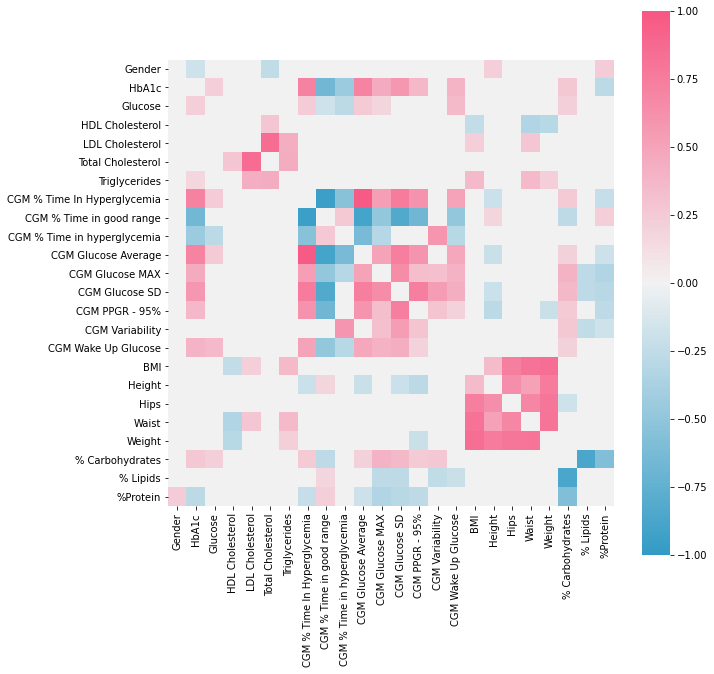

In [65]:
from scipy.stats.stats import pearsonr

def do_correl_pearson_numb(ser1, ser2):
        joined = pd.concat([ser1,ser2], axis = 1).dropna()
        return pearsonr(joined[ser1.name], joined[ser2.name])
    
def do_correl_pearson_numb_adj(ser1, ser2, covar):
        joined = pd.concat([ser1,ser2, covar], axis = 1).dropna()
        return  partial_corr(joined, ser1.name,ser2.name, covar.name)[['r', 'p-val']].values[0]

import seaborn as sns
res_bacteria_pvalue_sp  = pd.DataFrame(columns =pers_feat_renamed.columns )
res_bacteria_coeff_sp  = pd.DataFrame(columns =pers_feat_renamed.columns )


for col1 in pers_feat_renamed.columns:
    for col2 in pers_feat_renamed.columns:
        if col1==col2 or col2=='Age' or col1=='Age':
            continue

        res_bacteria_pvalue_sp.loc[col1, col2] = do_correl_pearson_numb_adj(pers_feat_renamed[col1], pers_feat_renamed[col2], pers_feat_renamed['Age'])[1]
        res_bacteria_coeff_sp.loc[col1, col2] = do_correl_pearson_numb_adj(pers_feat_renamed[col1], pers_feat_renamed[col2], pers_feat_renamed['Age'])[0]
        
        



sign_pval = pd.DataFrame()

for col in pers_feat_renamed.columns:
    if col=='Age':
        continue
    print(col)
    new_pval =  fdr(res_bacteria_pvalue_sp[col]).sort_values()
    signif = new_pval[new_pval<0.11]
    if signif.shape[0]>0:
        for ind in signif.index:
            print(ind, signif.loc[ind])
            sign_pval.loc[ind, col] = res_bacteria_coeff_sp.loc[ind, col]
            
matplotlib.rcParams.update({'font.size': 10})

plt.rcParams['figure.figsize'] = [10, 10]
cmap = sns.diverging_palette(230,0, 90, 60, as_cmap=True)
# plot heatmap
sns.heatmap(sign_pval.loc[sign_pval.columns].fillna(0), annot=False, fmt=".2f", 
           linewidths=0, cmap=cmap, vmin=-1, vmax=1, square=True)

In [66]:
def do_correl_pearson_adj(ser1, ser2, covar):
    joined = pd.concat([ser1,ser2, covar], axis = 1).dropna()
    
    
    fig, ax =  plt.subplots()
    cm = plt.cm.get_cmap('RdYlBu')
    xy = covar.loc[joined.index]
    z = xy
    sc = plt.scatter(joined[ser1.name], joined[ser2.name], c=z, vmin=0, vmax=60, s=35, cmap=cm)
    ax.set_xlabel(ser1.name)
    ax.set_ylabel(ser2.name)
    plt.colorbar(sc)
    plt.show()
    return  partial_corr(joined, ser1.name,ser2.name, covar.name)[['r', 'p-val']].values



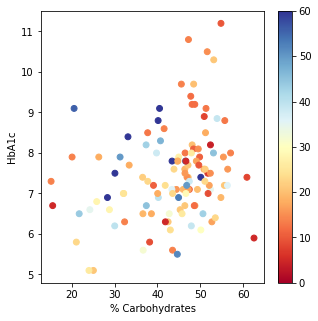

array([[0.26653405, 0.00325471]])

In [67]:
plt.rcParams['figure.figsize'] = [5, 5]
do_correl_pearson_adj(pers_feat_renamed['% Carbohydrates'], pers_feat_renamed['HbA1c'], pers_feat_renamed['Age'])

In [68]:
pers_feat_renamed.columns

Index(['Desease Duration', 'Gender', 'HbA1c', 'Glucose', 'HDL Cholesterol',
       'LDL Cholesterol', 'Total Cholesterol', 'Triglycerides',
       'CGM % Time In Hyperglycemia', 'CGM % Time in good range',
       'CGM % Time in hyperglycemia', 'CGM Glucose Average', 'CGM Glucose MAX',
       'CGM Glucose SD', 'CGM PPGR - 95%', 'CGM Variability',
       'CGM Wake Up Glucose', 'BMI', 'Height', 'Hips', 'Waist', 'Weight',
       '% Carbohydrates', '% Lipids', '%Protein', 'Age'],
      dtype='object')

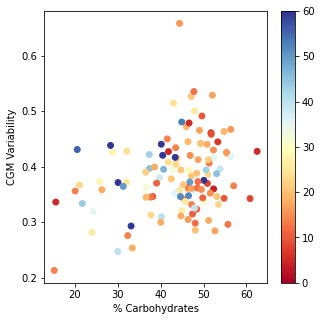

array([[0.26920198, 0.00294728]])

In [69]:
plt.rcParams['figure.figsize'] = [5, 5]
do_correl_pearson_adj(pers_feat_renamed['% Carbohydrates'], pers_feat_renamed['CGM Variability'], pers_feat_renamed['Age'])

In [70]:
X_av['RegistrationCode'].astype(int).astype(str).values

array(['2773601', '2705869', '2565375', '2753011', '2527367', '2940942',
       '2731663', '2149698', '2011588', '2529577', '2767492', '2590032',
       '2161740', '2580919', '2772936', '2032431', '2787563', '2953310',
       '2341635', '2152850', '2347848', '2179877', '2550841', '2394494',
       '2842722', '2602050', '2389693', '2768815', '2082508', '2295091',
       '2605343', '2059615', '2884721', '2859637', '2476957', '2984731',
       '2942935', '2105277', '2399467', '2805036', '2345589', '2870689',
       '2823868', '2708497', '2936379', '2925797', '2010578', '2731705',
       '2928687', '2103540', '2859961', '2291387', '2091594', '2454199',
       '2696293', '2205761', '2671824', '2312966', '2656143', '2604953',
       '2264805', '2554360', '2902755', '2380640', '2222186', '2720736',
       '2266842', '2883048', '2434655', '2677865', '2879802', '2737013',
       '2546458', '2223758', '2311735', '2554949', '2624552', '2297147',
       '2611664', '2339080', '2866904', '2998285', 

In [71]:
from DataLoaders import GutMBLoader
from skbio.diversity.alpha import shannon
import numpy as np
import pandas as pd

mbl = GutMBLoader.GutMBLoader()
mbld = mbl.get_data(df = 'segata_species', study_ids=6, groupby_reg='largest', take_log = True, min_col_present_frac=0.25)
micr = mbld.df

micr_md = mbld.df_metadata['RegistrationCode'].astype(float)
micr = micr.join(micr_md).set_index('RegistrationCode')

#celiac patients

micr = micr[~micr.index.isin(['2103540',  '2130360', '2311735', '2718102'])]

micr = micr[micr.index.isin(X_av['RegistrationCode'].astype(int).astype(str).values)]

micr.to_csv(os.path.join(global_path, 'microbiome_abundances.csv'))

/home/godnean/.local/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
/home/godnean/PycharmProjects/LabData/LabData/DataLoaders/MBLoader.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_index(inplace=True)


shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
Eubacterium_sp_CAG_115_sSGB__4191 0.07351524823278847
shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
Bifidobacterium_bifidum_sSGB__17256 0.07723891437522969
Clostridium_sp_CAG_122_sSGB__4659 0.09166852254243918
Blautia_sp_sSGB__4826 0.09884799640110531
shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
Eubacterium_rectale_sSGB__4933 0.02639986431917883
shape!!! (147,)
Eubacterium_rectale_sSGB__4933 0.09373120601527542
shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
shape!!! (147,)
Roseburia_sp_CAG_100_sSGB__4882 0.004758764500199147
Clostridium_sp_CAG_58_sSGB__4721 0.08707630126043775
shape!!! (147,)
shape!!! (147,)
Roseburia_sp_CAG_100_sSGB__4882 0.01451034501818171
Clostridium_sp_sSGB__4715 0.04285373949483566
Firmicutes_bacterium_CAG_102_sSGB__5190 0.050772143784488355
Eubacterium_sp_CAG_115_sSGB

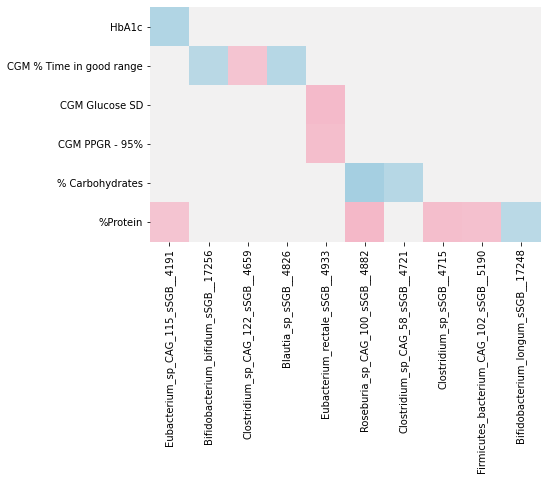

In [73]:
def rename_bact_name(x):
    if len(x.split('|'))==10:
        return x.split('|')[6].replace('s__', '')+'_'+x.split('|')[9]
    else:
        return x

do_a_heatmap_and_corr_matrix(micr, pers_feat_renamed, 'bacterial species phenotypes')

/home/godnean/PycharmProjects/LabData/LabData/DataLoaders/MBLoader.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_index(inplace=True)


shape!!! (126,)
shape!!! (126,)
shape!!! (126,)
Eubacterium_gSGB__3175 0.07320053624064382
shape!!! (126,)
shape!!! (126,)
shape!!! (126,)
shape!!! (126,)
shape!!! (126,)
shape!!! (126,)
shape!!! (126,)
shape!!! (126,)
shape!!! (126,)
shape!!! (126,)
Roseburia_gSGB__3644 0.08032598247234723
shape!!! (126,)
Lachnospiraceae_unclassified_gSGB__3638 0.013488386303225014
shape!!! (126,)
Lachnospiraceae_unclassified_gSGB__3638 0.03523860226799881
shape!!! (126,)
shape!!! (126,)
shape!!! (126,)
shape!!! (126,)
Akkermansia_gSGB__6531 0.045452777266650125
shape!!! (126,)
shape!!! (126,)
shape!!! (126,)
shape!!! (126,)
Roseburia_gSGB__3612 0.0010331100526642949
Clostridium_gSGB__3533 0.07443580312157982
Bifidobacterium_gSGB__10625 0.07908396026292122
Bacteroides_gSGB__1372 0.09024123067060434
shape!!! (126,)
Firmicutes_unclassified_gSGB__9715 0.05498844544706818
Roseburia_gSGB__3612 0.07138327479999515
shape!!! (126,)
Roseburia_gSGB__3612 0.004531344755571324


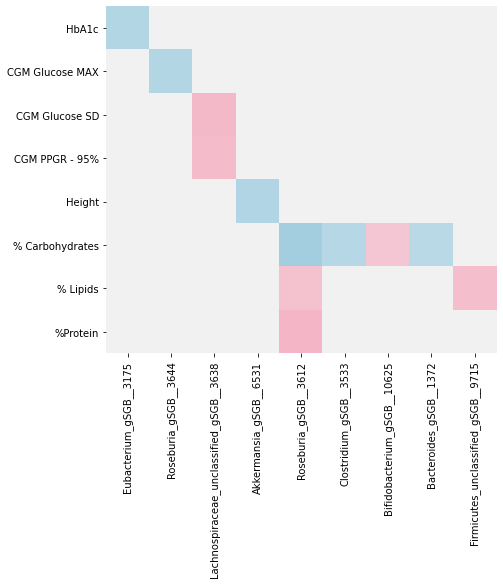

In [74]:
def rename_bact_name(x):
    if len(x.split('|'))==8:
        return x.split('|')[5].replace('g__', '')+'_'+x.split('|')[7]
    else:
        return x
    

mbld = mbl.get_data(df = 'segata_genus', study_ids=6, groupby_reg='largest', take_log = True, min_col_present_frac=0.25)
micr = mbld.df

micr_md = mbld.df_metadata['RegistrationCode'].astype(float)
micr = micr.join(micr_md).set_index('RegistrationCode')

do_a_heatmap_and_corr_matrix(micr, pers_feat_renamed, 'bacterial genus phenotypes')

/home/godnean/PycharmProjects/LabData/LabData/DataLoaders/MBLoader.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_index(inplace=True)


shape!!! (73,)
shape!!! (73,)
shape!!! (73,)
Eubacteriaceae_fSGB__1325 0.023786802547809262
Clostridiaceae_fSGB__1422 0.028877174294013156
Lachnospiraceae_fSGB__1215 0.05932977021024626
shape!!! (73,)
shape!!! (73,)
Firmicutes_unclassified_fSGB__1226 0.07594556306208931
Oxalobacteraceae_fSGB__2429 0.08224384610701693
shape!!! (73,)
shape!!! (73,)
shape!!! (73,)
shape!!! (73,)
Clostridiaceae_fSGB__1422 0.026340639212637098
Eubacteriaceae_fSGB__1472 0.02857793656743072
shape!!! (73,)
Clostridiaceae_fSGB__1422 0.009311812171323621
Eubacteriaceae_fSGB__1325 0.06922958527285908
Lachnospiraceae_fSGB__1428 0.07635338631041748
Eubacteriaceae_fSGB__1472 0.08246512644241644
shape!!! (73,)
shape!!! (73,)
Eubacteriaceae_fSGB__1472 0.02731440944774482
Clostridiaceae_fSGB__1422 0.08904908575090623
shape!!! (73,)
shape!!! (73,)
Clostridiaceae_fSGB__1422 0.047639018995760715
Barnesiellaceae_fSGB__604 0.0967856950199807
shape!!! (73,)
shape!!! (73,)
shape!!! (73,)
shape!!! (73,)
shape!!! (73,)
Akkerman

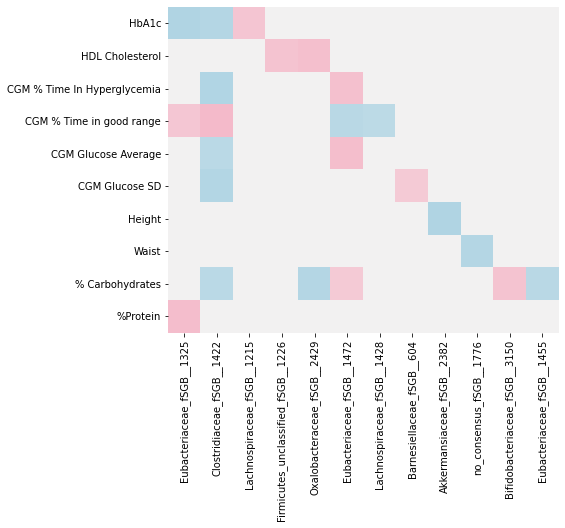

In [75]:
def rename_bact_name(x):
    if len(x.split('|'))==6:
        return x.split('|')[4].replace('f__', '')+'_'+x.split('|')[5]
    else:
        return x
    

mbld = mbl.get_data(df = 'segata_family', study_ids=6, groupby_reg='largest', take_log = True, min_col_present_frac=0.25)
micr = mbld.df

micr_md = mbld.df_metadata['RegistrationCode'].astype(float)
micr = micr.join(micr_md).set_index('RegistrationCode')

do_a_heatmap_and_corr_matrix(micr, pers_feat_renamed, 'bacterial family phenotypes')

In [162]:
corr_df = pd.DataFrame(columns =['number', 'corr'])

In [163]:
do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])

(0.6455955891882269, 3.9012998261825155e-06)

In [349]:
#pers_feat = cgm_features[[col for col in cgm_features.columns if col not in excl_columns]]

pers_feat = pers_feat.reset_index().set_index('ConnectionID')
age = pers_feat['Age']
pred_real1 = pd.read_csv(os.path.join(global_path, 'predicted_vs_measured_ppgr_complete.csv')).set_index(['ConnectionID', 'MealEventID'])



per_pers_corr = pd.Series(index = set(pred_real1.index.get_level_values(0)))

for con in set(pred_real1.index.get_level_values(0)):
   # print pearsonr(pred_real.loc[con, 'y_test'], pred_real.loc[con, 'y_pred'])
    per_pers_corr.loc[con] = pearsonr(pred_real1.loc[con, 'y_test'], pred_real1.loc[con, 'y_pred'])[0]

adults = age[age<12].index
corr_df.loc['children ','number'] =  len(adults)
corr_df.loc['children ','corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
corr_df.loc['children ','pers_corr']  = per_pers_corr.loc[adults].mean()



adults = age[age>12][age<19].index


print('adolescents ', len(adults))
corr_df.loc['adolescents ','number'] =  len(adults)
corr_df.loc['adolescents ','corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
corr_df.loc['adolescents ','pers_corr']  = per_pers_corr.loc[adults].mean()
adults = age[age>18].index
print('adults ', len(adults))
corr_df.loc['adults ','number'] =  len(adults)
corr_df.loc['adults ','corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
corr_df.loc['adults ','pers_corr']  = per_pers_corr.loc[adults].mean()


hba1c = pers_feat['bt__hba1c']


adults = hba1c[hba1c<=7].index

print('low_hba1c ', len(adults))
corr_df.loc['low_hba1c ','number'] =  len(adults)
corr_df.loc['low_hba1c ','corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
corr_df.loc['low_hba1c ','pers_corr']  = per_pers_corr.loc[adults].mean()
adults = hba1c[hba1c>7][hba1c<=8].index

print('middle_hba1c ', len(adults))
corr_df.loc['middle_hba1c ','number'] =  len(adults)
corr_df.loc['middle_hba1c ','corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
corr_df.loc['middle_hba1c ','pers_corr']  = per_pers_corr.loc[adults].mean()
print('high_hba1c')
adults = hba1c[hba1c>8].index

print('high_hba1c ', len(adults))
corr_df.loc['high_hba1c ','number'] =  len(adults)
corr_df.loc['high_hba1c ','corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
corr_df.loc['high_hba1c ','pers_corr']  = per_pers_corr.loc[adults].mean()



adults = pers_feat[pers_feat['variability']<pers_feat['variability'].quantile(0.33)].index
print('low_variability ', len(adults))
corr_df.loc['low_variability ','number'] =  len(adults)
corr_df.loc['low_variability ','corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
corr_df.loc['low_variability ','pers_corr']  = per_pers_corr.loc[adults].mean()

#[cgm_features['variability']<cgm_features['variability'].quantile(0.66)].index

adults = pers_feat[pers_feat['variability']>=pers_feat['variability'].quantile(0.33)]
adults =adults [adults['variability']<pers_feat['variability'].quantile(0.66)].index
print('middle_variability ', len(adults))
corr_df.loc['middle_variability ','number'] =  len(adults)
corr_df.loc['middle_variability ','corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
corr_df.loc['middle_variability ','pers_corr']  = per_pers_corr.loc[adults].mean()


adults = pers_feat[pers_feat['variability']>pers_feat['variability'].quantile(0.66)].index


#[cgm_features['variability']<cgm_features['variability'].quantile(0.66)].index
print('high_variability ', len(adults))
corr_df.loc['high_variability ','number'] =  len(adults)
corr_df.loc['high_variability ','corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
corr_df.loc['high_variability ','pers_corr']  = per_pers_corr.loc[adults].mean()

adults = pers_feat[pers_feat['time_in_hypo']<pers_feat['time_in_hypo'].quantile(0.33)].index
print('low_hypo', len(adults))
corr_df.loc['low_hypo','number'] =  len(adults)
corr_df.loc['low_hypo','corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
corr_df.loc['low_hypo','pers_corr']  = per_pers_corr.loc[adults].mean()



adults = pers_feat[pers_feat['time_in_hypo']>=pers_feat['time_in_hypo'].quantile(0.33)]
adults = adults[adults['time_in_hypo']<pers_feat['time_in_hypo'].quantile(0.66)].index

print('middle_hypo', len(adults))
corr_df.loc['middle_hypo','number'] =  len(adults)
corr_df.loc['middle_hypo','corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
corr_df.loc['middle_hypo','pers_corr']  = per_pers_corr.loc[adults].mean()




adults = pers_feat[pers_feat['time_in_hypo']>pers_feat['time_in_hypo'].quantile(0.66)].index
print('high_hypo', len(adults))
corr_df.loc['high_hypo','number'] =  len(adults)
corr_df.loc['high_hypo','corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
corr_df.loc['high_hypo','pers_corr']  = per_pers_corr.loc[adults].mean()




/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


adolescents  32
adults  68
low_hba1c  42
middle_hba1c  52
high_hba1c
high_hba1c  26
low_variability  40
middle_variability  39
high_variability  41
low_hypo 40
middle_hypo 39
high_hypo 41


In [350]:
for i in set(X_av['Insulin pump company'].values):
    adults  = X_av[X_av['Insulin pump company']==i].index
    if len(adults)>5:
        corr_df.loc['ins_'+i,'number'] =  len(adults)
        corr_df.loc['ins_'+i,'corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
        corr_df.loc['ins_'+i,'pers_corr']  = per_pers_corr.loc[adults].mean()



In [351]:
for i in set(X_av['CGM company'].values):
    adults  = X_av[X_av['CGM company']==i].index
    if len(adults)>5:
        corr_df.loc['cgm_'+i,'number'] =  len(adults)
        corr_df.loc['cgm_'+i,'corr']  = do_correl_pearson_numb(pred_real1.loc[adults]['y_pred'], pred_real1.loc[adults]['y_test'])[0]
        corr_df.loc['cgm_'+i,'pers_corr']  = per_pers_corr.loc[adults].mean()


In [352]:
corr_df

,number,corr,pers_corr
children,17,0.557709,0.489198
adolescents,32,0.525995,0.414268
adults,68,0.617137,0.550425
low_hba1c,42,0.56327,0.511347
middle_hba1c,52,0.573942,0.500283
high_hba1c,26,0.64263,0.503844
low_variability,40,0.615664,0.540803
middle_variability,39,0.5975,0.499070
high_variability,41,0.548389,0.464614
low_hypo,40,0.637247,0.519594


In [353]:
per_pers_corr.median()

0.5070104883906237

In [354]:
do_correl_pearson_numb(pred_real1['y_pred'], pred_real1['y_test'])[0]

0.5883980866746824

In [355]:
age[age>18].index

Int64Index([2879, 3024, 3026, 3027, 3029, 3030, 3031, 3032, 3034, 3036, 3037,
            3038, 3039, 3040, 3041, 3043, 3242, 3244, 3248, 3250, 3520, 3522,
            3524, 3526, 3541, 3542, 3543, 4070, 4074, 4076, 4078, 4079, 4080,
            4081, 4082, 4083, 4084, 4085, 4086, 4087, 4090, 4170, 4171, 4172,
            4174, 4176, 4177, 4179, 4429, 4455, 4456, 5409, 5413, 5415, 5417,
            5420, 5424, 5425, 5426, 5427, 5428, 5429, 5531, 5532, 5535, 5537,
            5538, 5943],
           dtype='int64', name='ConnectionID')

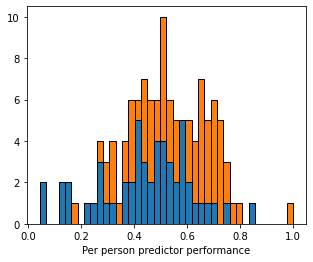

In [356]:
stacked_hist(per_pers_corr.loc[age[age<19].index], per_pers_corr.loc[age[age>18].index], 'Per person predictor performance')

In [ ]:
bt__hba1c
desease_duration
number_of_meals_all
number_of_meals_predictor

In [186]:
for col in per_pers_corr.columns:
    if col not in foods:
         print(col)

predictions_accuracy
RegistrationCode
InsulinBeforeMeal_60_0
InsulinBeforeMeal_30_15
InsulinBeforeMeal_240_15
InsulinBeforeMeal_120_15
InsulinBeforeMeal_90_15only_bolus
InsulinBeforeMeal_60_15only_bolus
BolusInsulinMeal_90_15
Exercise_timeToLast
GlucoseTrend_120
GlucoseTrend_60
GlucoseTrend_30
SugarAtMealStart
TimeOfTheDat
10P_Glucose
1P_Glucose
2P_Glucose
5P_Glucose
90P_Glucose
95P_Glucose
98P_Glucose
99P_Glucose
BMI
BodyWeight
Gender
Height
Hips
Max_Glucose
Median_Glucose
Min_Glucose
Waist
Age
WakeupGlucose
GeneSetMap_Perc
HGMapped_perc
IsGenotek
PostQC
HasMG
k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__1292|gSGB__3109|sSGB__4121
k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__1443|gSGB__3564|sSGB__4767
k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__1443|gSGB__3565|sSGB__4768
k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|g__unknown|s__unknown|fSGB__2377|gSGB__6516|sSG

In [277]:
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu
X,y = preprocess_X(X_path, control_predictor=False, max_gl=True, without_micr=True)


pred_real1 = pd.read_csv(os.path.join(global_path, 'predicted_vs_measured_maxglu_complete.csv')).set_index(['ConnectionID', 'MealEventID'])


per_pers_corr = pd.Series(index = set(pred_real1.index.get_level_values(0)))





for con in set(pred_real1.index.get_level_values(0)):
   # print pearsonr(pred_real.loc[con, 'y_test'], pred_real.loc[con, 'y_pred'])
    per_pers_corr.loc[con] = pearsonr(pred_real1.loc[con, 'y_test'], pred_real1.loc[con, 'y_pred'])[0]

tf = pd.read_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/TestFoodsDF_t1d.csv').set_index(['ConnectionID','EventID'])




X_t = pd.read_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/predictor/meal_features_t1d_segata.csv').set_index(['ConnectionID', 'MealEventID'])


X_bad = X_t[~X_t.index.isin(X.index)]


per_pers_corr  = pd.DataFrame(per_pers_corr)

for ind in per_pers_corr.index:
    per_pers_corr.loc[ind, 'Age'] = X.loc[ind, 'Age'].mean()
    per_pers_corr.loc[ind, 'Gender'] = X.loc[ind, 'Gender'].mean()
    per_pers_corr.loc[ind, 'SugarAtMealStart'] = X.loc[ind, 'SugarAtMealStart'].mean()
    per_pers_corr.loc[ind, 'HbA1C%'] = X.loc[ind, 'bt__hba1c'].mean()
    per_pers_corr.loc[ind, 'BMI'] = X.loc[ind, 'BMI'].mean()
    per_pers_corr.loc[ind, 'number_of_meals'] = X.loc[ind].shape[0]
    per_pers_corr.loc[ind, 'number_of_meals_per_day'] = per_pers_corr.loc[ind, 'number_of_meals']/\
                                                                   max(1, (pd.to_datetime(X_t.loc[ind]['Timestamp']).max() \
                                                         - pd.to_datetime(X_t.loc[ind]['Timestamp']).min()).days)
    
    per_pers_corr.loc[ind, 'carb_perc'] = X_t.loc[ind, 'Carbohydrate_g'].sum()*4/X_t.loc[ind, 'Energy_kcal'].sum()
    per_pers_corr.loc[ind, 'fat_perc'] = X_t.loc[ind, 'TotalLipid_g'].sum()*9/X_t.loc[ind, 'Energy_kcal'].sum()
    per_pers_corr.loc[ind, 'protein_perc'] = X_t.loc[ind, 'Protein_g'].sum()*4/X_t.loc[ind, 'Energy_kcal'].sum()
 #   per_pers_corr.loc[ind, 'mean_energy_per_weight'] = X_t.loc[ind, 'Energy_kcal'].mean()/X_t.loc[ind, 'BodyWeight'].mean()
 #   per_pers_corr.loc[ind, 'sum_energy_per_weight_per_day'] = X_t.loc[ind, 'Energy_kcal'].sum()/X_t.loc[ind, 'BodyWeight'].mean()/\
    max(1, (pd.to_datetime(X_t.loc[ind]['Timestamp']).max() \
                                                         - pd.to_datetime(X_t.loc[ind]['Timestamp']).min()).days)
    pf = pers_feat.set_index('ConnectionID')
    if ind in pf.index:
        per_pers_corr.loc[ind, 'variability'] = pf.loc[ind, 'variability']
        per_pers_corr.loc[ind, 'mean_glucose'] = pf.loc[ind, 'average']
    if ind in X_bad.index:
        per_pers_corr.loc[ind, 'bad_meals'] = X_bad.loc[ind].shape[0]
        per_pers_corr.loc[ind, '%_bad_meals'] = X_bad.loc[ind].shape[0]*1.0/(X.loc[ind].shape[0]+X_bad.loc[ind].shape[0])
        
    if ind in tf.index.get_level_values(0):
        per_pers_corr.loc[ind, 'number_of_test_foods'] = tf.loc[ind].shape[0]

    



def compare_2_groups(df, group1, group2, group1_name='good_prediction', group2_name='bad_prediction'):
    comparison_table = pd.DataFrame(columns = [group1_name+' mean', group1_name+' std',\
                                               group2_name+' mean', group2_name+' std',
                                              'ttest_pvalue'])
    signif_cols = []
    for col in df.columns:
        A=df[col].loc[group1].dropna().values
        B=df[col].loc[group2].dropna().values
        if len(A)<20:
            continue
        comparison_table.loc[col, group1_name+' mean'] = df[col].loc[group1].dropna().mean()
        comparison_table.loc[col, group1_name+' std'] =  df[col].loc[group1].dropna().std()
        comparison_table.loc[col, group2_name+' mean'] = df[col].loc[group2].dropna().mean()
        comparison_table.loc[col, group2_name+' std'] =  df[col].loc[group2].dropna().std()
        comparison_table.loc[col, 'ttest_pvalue'] =  ttest_ind(A, B)[1]
        comparison_table.loc[col, 'mw_pvalue'] =  mannwhitneyu(A, B)[1]
        if ttest_ind(A, B)[1]<0.05:
         #   print(col)
            signif_cols = signif_cols+[col]
          #  fig, ax = plt.subplots()
          #  draw_plot(A, B, col)
        #    plt.close()
    return comparison_table, signif_cols
per_pers_corr = per_pers_corr.rename(columns = {0:'predictions_accuracy'})
mean_corr = per_pers_corr['predictions_accuracy'].mean()
accur = compare_2_groups(per_pers_corr, per_pers_corr[per_pers_corr['predictions_accuracy']>0.58].index, \
                 per_pers_corr[per_pers_corr['predictions_accuracy']<0.43].index)[0].round(3)

accur = accur[~accur.index.isin(['predictions_accuracy'])]
accur['pvalue_fdr'] = fdr(accur['mw_pvalue'])
accur.to_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/bad_and_good_predictions.csv')

after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377
(0.5671078850401298, 0.0)


0

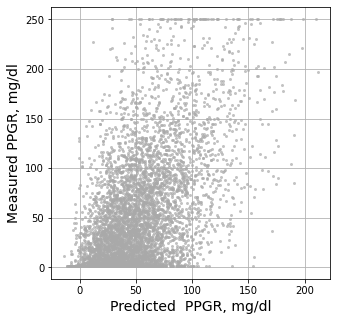

In [320]:
X,y = preprocess_X(X_path, control_predictor=False, max_gl=False, without_micr=False)

model = xgboost.XGBRegressor(learning_rate = 0.005, n_estimators = 3000, reg_lambda = 10, subsample = 0.75, \
                                        colsample_bytree = 0.4, max_depth = 60, reg_alpha = 10, min_child_weight = 50, nthread = 4, seed = 5)



new_x = X.reset_index()[['ConnectionID', 'Carbohydrate_g']].sort_values(['ConnectionID', 'Carbohydrate_g']).reset_index().reset_index()


groups2 = (new_x['ConnectionID']*10+new_x['level_0']%2).values
X = X.reset_index().sort_values(['ConnectionID', 'Carbohydrate_g']).set_index(['ConnectionID', 'MealEventID'])
X = X[X.index.isin(y.index)]
y = y.loc[X.index]
from sklearn.model_selection import GroupKFold

def cvfolds(X):
    res = []
    for train, test in KFold( n_splits = 10, shuffle = True, random_state =6).split(X.groupby(X.index.get_level_values(0))):
        testfilt = X.index.get_level_values(0).isin(X.index.levels[0][test])
        res.append((np.where(~testfilt), np.where(testfilt)))
    return res



cv2=list(group_kfold.split(X, y, groups2))


results = cross_val_predict(model, X.values, y.values, cv=cv2)

pred_real2 = pd.DataFrame(columns = ['y_test', 'y_pred'])
pred_real2['y_test']=y
i=0
for ind in y.index:
    pred_real2.loc[ind, 'y_pred']=results[i]
    i = i+1
do_correl_pearson(pred_real2['y_pred'], pred_real2['y_test'], name2 = 'Measured PPGR, mg/dl', name1 = 'Predicted  PPGR, mg/dl')    

after merging and crowd filtering 6871
after removing with carbs more than 200 6838
after removing withiout basal insulin 6701
after removing withiout sugar in meal start less than 50 6486
after removing meals that are more than 15 days after the forst 6377
(0.4773804709597756, 0.0)


0

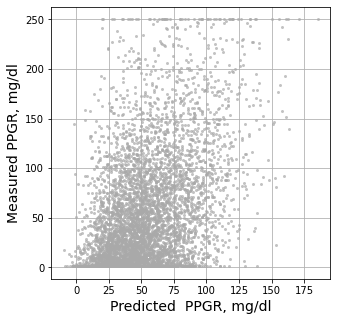

In [322]:
import numpy as np
from sklearn.model_selection import GroupKFold


X,y = preprocess_X(X_path, control_predictor=False, max_gl=False, without_micr=False)

X = X[X.index.isin(y.index)]
y = y.loc[X.index]

model = xgboost.XGBRegressor(learning_rate = 0.005, n_estimators = 3000, reg_lambda = 10, subsample = 0.75, \
                                        colsample_bytree = 0.4, max_depth = 60, reg_alpha = 10, min_child_weight = 50, nthread = 4, seed = 5)




groups =cvfolds(X)

group_kfold = GroupKFold(n_splits=10)

group_kfold.split(X, y, X.reset_index()['ConnectionID'].values)


results3 = cross_val_predict(model, X.values, y.values, cv=list(group_kfold.split(X, y, X.reset_index()['ConnectionID'].values)))

pred_real3 = pd.DataFrame(columns = ['y_test', 'y_pred'])
pred_real3['y_test']=y
i=0
for ind in y.index:
    pred_real3.loc[ind, 'y_pred']=results3[i]
    i = i+1
do_correl_pearson(pred_real3['y_pred'], pred_real3['y_test'], name2 = 'Measured PPGR, mg/dl', name1 = 'Predicted  PPGR, mg/dl')    



